## Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from xgboost import XGBClassifier

from utils import *

#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc

from imblearn.over_sampling import SMOTE

SEED = 666

# magic word for producing visualizations in notebook
%matplotlib inline

# and setting the size of all plots.
plt.rcParams['figure.figsize'] = [11, 7]

Using TensorFlow backend.


## Load Dataset

In [2]:
# The C engine doesn't support RegEx so we set it to Python to avoid the warning
census = pd.read_csv('data/census-income.data', header=None, sep=',\s', na_values=['?', 'Do not know', 'Not identifiable'], engine='python')

In [3]:
census_columns = [
    'age',
    'class of worker',
    'detailed industry recode',
    'detailed occupation recode',
    'education',
    'wage per hour',
    'enroll in edu inst last wk',
    'marital status',
    'major industry code',
    'major occupation code',
    'race',
    'hispanic origin',
    'sex',
    'member of a labor union',
    'reason for unemployment',
    'full or part time employment stat',
    'capital gains',
    'capital losses',
    'dividends from stocks',
    'tax filer stat',
    'region of previous residence',
    'state of previous residence',
    'detailed household and family stat',
    'detailed household summary in household',
    'instance weight',
    'migration code-change in msa',
    'migration code-change in reg',
    'migration code-move within reg',
    'live in this house 1 year ago',
    'migration prev res in sunbelt',
    'num persons worked for employer',
    'family members under 18',
    'country of birth father',
    'country of birth mother',
    'country of birth self',
    'citizenship',
    'own business or self employed',
    'fill inc questionnaire for veteran\'s admin',
    'veterans benefits',
    'weeks worked in year',
    'year',
    'income class'
]

features_to_drop = [
    'instance weight', # Ignored
    # more than 70% values missing
    'enroll in edu inst last wk',
    'member of a labor union',
    'reason for unemployment',
    'region of previous residence',
    'state of previous residence',
    'migration prev res in sunbelt',
    'family members under 18',
    "fill inc questionnaire for veteran's admin",
    # more than 50% values missing
    'class of worker',
    'major industry code',
    'major occupation code',
    'migration code-change in msa',
    'migration code-change in reg',
    'migration code-move within reg',
    'live in this house 1 year ago',
    # Vlad Manolache
    "year", # good call Vlad Manolache
    'capital gains',
    'capital losses'
]

categorical_features = [
    #'class of worker',
    'detailed industry recode',
    'detailed occupation recode',
    'education',
    'marital status',
    #'major industry code',
    #'major occupation code',
    'race',
    'hispanic origin',
    'sex',
    'full or part time employment stat',
    'tax filer stat',
    'detailed household and family stat',
    'detailed household summary in household',
    #'migration code-change in msa',
    #'migration code-change in reg',
    #'migration code-move within reg',
    #'live in this house 1 year ago',
    'country of birth father',
    'country of birth mother',
    'country of birth self',
    'citizenship',
    'own business or self employed',
    'veterans benefits',
    #'year'
]

numerical_features = [
    'age',
    'wage per hour',
    #'capital gains',
    #'capital losses',  
    'capital gains loss', #Vlad Manolache
    'dividends from stocks',
    'num persons worked for employer',
    'weeks worked in year'
]

census.columns = census_columns
census.head()

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital status,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,income class
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


In [4]:
census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   age                                         199523 non-null  int64  
 1   class of worker                             199523 non-null  object 
 2   detailed industry recode                    199523 non-null  int64  
 3   detailed occupation recode                  199523 non-null  int64  
 4   education                                   199523 non-null  object 
 5   wage per hour                               199523 non-null  int64  
 6   enroll in edu inst last wk                  199523 non-null  object 
 7   marital status                              199523 non-null  object 
 8   major industry code                         199523 non-null  object 
 9   major occupation code                       199523 non-null  object 
 

## Clean Dataset

In [5]:
class DefaultZero(dict):
    def __missing__(self, key):
        return 0

def clean_dataset(df):
    # replace field that contains Not in Universe with NaN
    df = df.replace(r'Not in universe\w*?', np.nan, regex=True)
    
    # Fill NaN
    df['hispanic origin'] = df['hispanic origin'].fillna(df['hispanic origin'].mode()[0])
    df['country of birth father'] = df['country of birth father'].fillna(df['country of birth father'].mode()[0])
    df['country of birth mother'] = df['country of birth mother'].fillna(df['country of birth mother'].mode()[0])
    df['country of birth self'] = df['country of birth self'].fillna(df['country of birth self'].mode()[0])
    
    # Feature Engineering
    df['sex'] = df['sex'].map({'Female': 0, 'Male': 1})
    
    # From Vlad Manolache
    # -------------------------

    # Collapse marrital status
    marrital_status_single = ['Never married', 'Separated', 'Divorced', 'Widowed']
    marrital_status_married = ['Married-civilian spouse present', 'Married-spouse absent', 'Married-A F spouse present']
    df['marital status'] = df['marital status'].replace(marrital_status_single, 0)
    df['marital status'] = df['marital status'].replace(marrital_status_married, 1)
    
    # Inspired by the winners
    map_education = {
        'Doctorate degree(PhD EdD)': 3,
        'Prof school degree (MD DDS DVM LLB JD)': 3,
        'Masters degree(MA MS MEng MEd MSW MBA)': 3,
        'Bachelors degree(BA AB BS)': 2,
        'Associates degree-academic program': 2,
        'Associates degree-occup /vocational': 2,
        'Some college but no degree': 1,
        '12th grade no diploma': 1,
        '11th grade': 1,
        '10th grade': 1,
        '9th grade': 1,
        'High school graduate': 1,
        '7th and 8th grade': 0,
        '5th or 6th grade': 0,
        '1st 2nd 3rd or 4th grade': 0,
        'Less than 1st grade': 0,
        'Children': 0
    }
    
    df['education'] = df['education'].map(map_education)
    
    # From Vlad Manolache
    df['capital gains loss'] = df['capital gains'] - df['capital losses']
    
    # From Jan Jakob Lameijer
    map_race = {
        'White': 1,
        'Black': 0,
        'Asian or Pacific Islander': 0,
        'Other': 0,
        'Amer Indian Aleut or Eskimo': 0
    }

    df['race'] = df['race'].map(map_race)

    map_hisp = {
        'All other': 0,
        'Mexican (Mexicano)': 1,
        'Mexican-American': 1,
        'Puerto Rican': 1,
        'Central or South American': 1,
        'Other Spanish': 1,
        'Chicano': 1,
        'Cuban': 1
    }
    df['hispanic origin'] = df['hispanic origin'].map(map_hisp)

    map_birth = DefaultZero({'United-States': 1})
    df['country of birth self'] = df['country of birth self'].map(map_birth)
    df['country of birth father'] = df['country of birth father'].map(map_birth)
    df['country of birth mother'] = df['country of birth mother'].map(map_birth)
    
    # From Andrei Ratushin
    
    #First - I shall collect grandchilds 18+, as their numbers are non-representative (<1%) in current segmentation
    df.loc[df['detailed household and family stat'].str.contains('Grandchild'),'detailed household and family stat']='Child 18+'
    df.loc[df['detailed household and family stat'].str.contains('Child'),'detailed household summary in household']='Child 18+'
    df.loc[df['detailed household and family stat'].str.contains('Child'),'detailed household and family stat']='Child 18+'
    
    # Drop features
    df = df.drop(features_to_drop, axis=1)
    
    # Encode income class column
    df['income class'] = df['income class'].map({'- 50000.': 0, '50000+.': 1})
    
    # Reduce memory usage
    df, _ = reduce_mem_usage(df)

    return df

In [6]:
census = clean_dataset(census)
census.head()

Memory usage of dataframe:  36.53387451171875  MB



___MEMORY USAGE AFTER COMPLETION:___
Memory usage is: 12.558599472045898 MB
This is 34.38% of the initial size


,age,detailed industry recode,detailed occupation recode,education,wage per hour,marital status,race,hispanic origin,sex,full or part time employment stat,...,num persons worked for employer,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,veterans benefits,weeks worked in year,income class,capital gains loss
0,73,0,0,1,0,0,1,0,0,Not in labor force,...,0,1,1,1,Native- Born in the United States,0,2,0,0,0
1,58,4,34,1,0,0,1,0,1,Children or Armed Forces,...,1,1,1,1,Native- Born in the United States,0,2,52,0,0
2,18,0,0,1,0,0,0,0,0,Not in labor force,...,0,0,0,0,Foreign born- Not a citizen of U S,0,2,0,0,0
3,9,0,0,0,0,0,1,0,0,Children or Armed Forces,...,0,1,1,1,Native- Born in the United States,0,0,0,0,0
4,10,0,0,0,0,0,1,0,0,Children or Armed Forces,...,0,1,1,1,Native- Born in the United States,0,0,0,0,0


In [7]:
census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 24 columns):
 #   Column                                   Non-Null Count   Dtype 
---  ------                                   --------------   ----- 
 0   age                                      199523 non-null  uint8 
 1   detailed industry recode                 199523 non-null  uint8 
 2   detailed occupation recode               199523 non-null  uint8 
 3   education                                199523 non-null  uint8 
 4   wage per hour                            199523 non-null  uint16
 5   marital status                           199523 non-null  uint8 
 6   race                                     199523 non-null  uint8 
 7   hispanic origin                          199523 non-null  uint8 
 8   sex                                      199523 non-null  uint8 
 9   full or part time employment stat        199523 non-null  object
 10  dividends from stocks                    199

In [8]:
unique_values(census[categorical_features])

detailed industry recode: [0, 4, 40, 34, 43, 37, 24, 39, 12, 35, 45, 3, 19, 29, 32, 48, 33, 23, 44, 36, 31, 30, 41, 5, 11, 9, 42, 6, 18, 50, 2, 1, 26, 47, 16, 14, 22, 17, 7, 8, 25, 46, 27, 15, 13, 49, 38, 21, 28, 20, 51, 10]
detailed occupation recode: [0, 34, 10, 3, 40, 26, 37, 31, 12, 36, 41, 22, 2, 35, 25, 23, 42, 8, 19, 29, 27, 16, 33, 13, 18, 9, 17, 39, 32, 11, 30, 38, 20, 7, 21, 44, 24, 43, 28, 4, 1, 6, 45, 14, 5, 15, 46]
education: [1, 0, 2, 3]
marital status: [0, 1]
race: [1, 0]
hispanic origin: [0, 1]
sex: [0, 1]
full or part time employment stat: ['Not in labor force', 'Children or Armed Forces', 'Full-time schedules', 'Unemployed full-time', 'Unemployed part- time', 'PT for non-econ reasons usually FT', 'PT for econ reasons usually PT', 'PT for econ reasons usually FT']
tax filer stat: ['Nonfiler', 'Head of household', 'Joint both under 65', 'Single', 'Joint both 65+', 'Joint one under 65 & one 65+']
detailed household and family stat: ['Other Rel 18+ ever marr not in subfam

## Split train and validation sets

In [9]:
X = census.drop('income class', axis=1)
y = census['income class']

In [10]:
y.mean()

0.06205800834991455

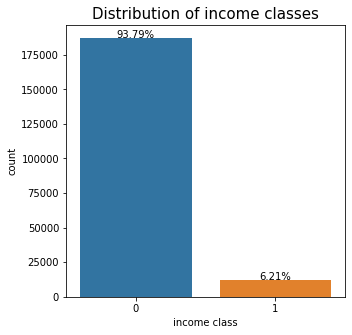

In [11]:
plt.figure(figsize=(5, 5))
total = census.shape[0]
ax = sns.countplot(x="income class", data=census)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 3,
            '{0:.2%}'.format(height/total),
            ha="center")
plt.title('Distribution of income classes', fontsize=15)
plt.show()

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

## Models

In [13]:
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
ratio

15.113264688067838

### Dimensionality Reduction

In [14]:
preprocessor = make_column_transformer(
    (Pipeline([
        ('num', SimpleImputer()),
        ('sc', StandardScaler()),
    ]), numerical_features),
    (Pipeline([
        ('num', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('enc', OneHotEncoder(categories='auto', sparse = False, handle_unknown='ignore'))
    ]), categorical_features),
    remainder='drop'
)

pipeline = Pipeline([
    ('pre', preprocessor),
    ('pca', PCA(random_state=SEED))
])

In [15]:
X_trans = pipeline.fit_transform(X_train)
pca = pipeline['pca']

# Reconstruct the DataFrame
transformed_cat_features = pipeline.named_steps['pre'].transformers_[1][1].named_steps['enc'].get_feature_names(categorical_features)
X_trans=pd.DataFrame(X_trans, columns=numerical_features+transformed_cat_features.tolist())
X_trans.head()

,age,wage per hour,capital gains loss,dividends from stocks,num persons worked for employer,weeks worked in year,detailed industry recode_0,detailed industry recode_1,detailed industry recode_2,detailed industry recode_3,...,citizenship_Foreign born- U S citizen by naturalization,citizenship_Native- Born abroad of American Parent(s),citizenship_Native- Born in Puerto Rico or U S Outlying,citizenship_Native- Born in the United States,own business or self employed_0,own business or self employed_1,own business or self employed_2,veterans benefits_0,veterans benefits_1,veterans benefits_2
0,2.257151,0.365931,-0.185215,-0.425866,-0.038539,-0.474261,-0.672448,-0.983695,0.384520,-0.103268,...,-9.870598e-15,-5.876768e-15,2.264828e-15,2.377029e-15,3.431464e-15,-4.488571e-15,2.502510e-15,-1.139320e-14,6.771640e-15,-6.193639e-15
1,1.018621,0.408795,-0.063983,-0.271466,-0.097780,-0.419720,-0.384882,-1.182465,0.001123,0.484228,...,2.281898e-15,-3.508115e-16,-3.204861e-15,1.505792e-15,1.683544e-15,3.794579e-16,3.541335e-17,4.745883e-15,-1.486957e-15,-2.402051e-16
2,-0.058175,2.384082,-0.861986,0.335576,-0.292164,0.006734,0.909999,0.368968,0.057933,-0.088011,...,4.639821e-16,-1.643889e-15,1.471387e-15,-7.061090e-16,-1.820195e-15,1.525952e-15,-1.364462e-16,1.293726e-15,-4.540103e-16,-8.306395e-16
3,-2.343013,-0.563197,0.272006,0.001727,0.023497,-0.311422,-0.089270,-0.750389,-0.118686,-0.157205,...,4.046482e-16,-2.230044e-16,2.884390e-16,4.491858e-19,8.201736e-17,-1.160644e-15,2.308238e-15,-6.273575e-16,-4.086063e-16,1.363481e-16
4,0.721110,0.048285,-0.044788,-0.218924,0.044103,-0.562051,-1.467497,0.531249,0.987215,-0.799148,...,2.954350e-15,-3.328321e-15,-5.200963e-15,3.554192e-15,-4.016349e-15,2.793638e-15,5.735407e-16,1.019144e-15,2.651463e-15,8.037766e-16


,Explained Cumulative Variance,Explained Variance Ratio,age,wage per hour,capital gains loss,dividends from stocks,num persons worked for employer,weeks worked in year,detailed industry recode_0,detailed industry recode_1,...,citizenship_Foreign born- U S citizen by naturalization,citizenship_Native- Born abroad of American Parent(s),citizenship_Native- Born in Puerto Rico or U S Outlying,citizenship_Native- Born in the United States,own business or self employed_0,own business or self employed_1,own business or self employed_2,veterans benefits_0,veterans benefits_1,veterans benefits_2
Dimension 1,0.2481,0.2481,0.3096,0.1383,0.0622,0.0451,0.4119,0.4612,-0.2214,0.0011,...,0.0074,0.0006,0.0002,-0.0114,-0.0405,0.0066,0.0338,-0.1854,0.0011,0.1844
Dimension 2,0.3504,0.1023,0.5963,-0.2534,0.0759,0.2460,-0.3648,-0.3172,0.1578,-0.0009,...,0.0133,-0.0003,0.0025,-0.0262,0.0434,-0.0032,-0.0402,-0.1128,0.0072,0.1056
Dimension 3,0.4318,0.0814,-0.1352,-0.0248,0.7208,0.6254,0.0507,0.0523,-0.0186,-0.0003,...,-0.0079,-0.0003,-0.0024,0.0290,-0.0082,0.0036,0.0047,0.0522,-0.0006,-0.0517
Dimension 4,0.4991,0.0673,0.1028,0.9192,-0.1419,0.2522,-0.1271,-0.1405,0.0599,-0.0008,...,-0.0040,-0.0015,-0.0018,0.0278,0.0178,-0.0027,-0.0151,0.0025,0.0017,-0.0042
Dimension 5,0.5614,0.0623,-0.1036,-0.2553,-0.6338,0.6678,0.1148,0.0771,-0.0376,-0.0003,...,-0.0140,-0.0010,-0.0044,0.0494,-0.0148,0.0007,0.0141,0.0130,-0.0023,-0.0107
Dimension 6,0.6183,0.0570,-0.0876,0.0619,-0.0657,0.1812,0.0299,0.0369,-0.0231,0.0023,...,0.0645,0.0088,0.0219,-0.2761,0.0134,-0.0029,-0.0105,0.0004,-0.0035,0.0032
Dimension 7,0.6705,0.0522,-0.2272,0.0243,0.1620,-0.0045,0.0096,-0.0107,0.0045,-0.0017,...,-0.0025,-0.0004,-0.0025,0.0057,0.0143,-0.0011,-0.0131,0.0530,-0.0095,-0.0436
Dimension 8,0.7132,0.0427,0.1271,-0.0152,0.1228,-0.0141,0.1594,-0.0265,-0.0121,-0.0015,...,0.0040,0.0004,0.0028,-0.0125,-0.0176,-0.0042,0.0219,-0.0999,-0.0063,0.1062
Dimension 9,0.7375,0.0243,-0.2140,-0.0074,0.0384,0.0287,-0.2909,-0.0152,-0.0668,0.0049,...,-0.0110,0.0002,-0.0003,-0.0051,-0.0379,0.0009,0.0370,-0.1557,-0.0067,0.1624
Dimension 10,0.7593,0.0218,-0.0164,-0.0053,0.0088,0.0101,0.6326,-0.3830,0.1958,-0.0067,...,0.0047,0.0003,0.0004,-0.0018,0.0501,-0.0107,-0.0394,-0.0286,0.0036,0.0249


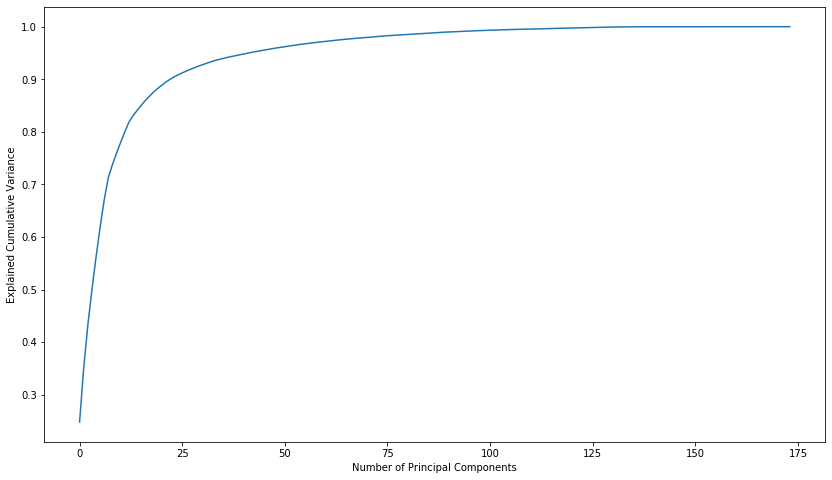

In [16]:
results = pca_results(X_trans, pipeline['pca'])
results.head(10)

In [17]:
n_components = 42

In [18]:
explained_variance = results.iloc[n_components, 0]
explained_variance

0.9513

#### Adapt pipeline

In [19]:
preprocessor = make_column_transformer(
    (Pipeline([
        ('num', SimpleImputer()),
        ('sc', StandardScaler()),
    ]), numerical_features),
    (Pipeline([
        ('num', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ( 'enc', OneHotEncoder(categories='auto', sparse = False, handle_unknown='ignore' ))
    ]), categorical_features),
    remainder='drop'
)

pipeline = Pipeline([
    ('pre', preprocessor),
    ('pca', PCA(n_components=n_components, random_state=SEED))
]) 

In [20]:
X_train_trans = pipeline.fit_transform(X_train)
X_val_trans = pipeline.transform(X_val)

In [21]:
eval_set = [(X_val_trans, y_val)]
fit_params={
    'eval_metric': 'auc',
    'early_stopping_rounds': 30,
    'callbacks': [xgb.callback.early_stop(30, maximize=True)],
    'eval_set' : eval_set,
}

#### Tune max_depth and min_child_weight

In [22]:
parameters = {
    'learning_rate': [0.1],
    'n_estimators': [10000],
    'max_depth': range(3,10,2),
    'min_child_weight': range(1,6,2),
    'gamma': [0.0],    
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'scale_pos_weight': [ratio],
    'random_state': [SEED],
    'tree_method': ['gpu_hist'],
    'objective': ['binary:logistic']
}

model = GridSearchCV(XGBClassifier(), param_grid=parameters, scoring='roc_auc', n_jobs=5, verbose=2)
model.fit(X_train_trans, y_train, **fit_params);

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  1.2min
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:  2.9min finished


Will train until validation_0-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.86471
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.89192
[2]	validation_0-auc:0.89959
[3]	validation_0-auc:0.90631
[4]	validation_0-auc:0.90878
[5]	validation_0-auc:0.91043
[6]	validation_0-auc:0.91251
[7]	validation_0-auc:0.91427
[8]	validation_0-auc:0.91421
[9]	validation_0-auc:0.91565
[10]	validation_0-auc:0.91754
[11]	validation_0-auc:0.91855
[12]	validation_0-auc:0.91917
[13]	validation_0-auc:0.92007
[14]	validation_0-auc:0.92076
[15]	validation_0-auc:0.92148
[16]	validation_0-auc:0.92332
[17]	validation_0-auc:0.92343
[18]	validation_0-auc:0.92370
[19]	validation_0-auc:0.92386
[20]	validation_0-auc:0.92414
[21]	validation_0-auc:0.92482
[22]	validation_0-auc:0.92538
[23]	validation_0-auc:0.92588
[24]	validation_0-auc:0.92587
[25]	validation_0-auc:0.92620
[26]	validation_0-auc:0.92700
[27]	validation_0-auc:0.92727
[28]	validation_0-auc:0.92772
[29]	validat

[264]	validation_0-auc:0.94262
[265]	validation_0-auc:0.94262
[266]	validation_0-auc:0.94263
[267]	validation_0-auc:0.94262
[268]	validation_0-auc:0.94265
[269]	validation_0-auc:0.94265
[270]	validation_0-auc:0.94265
[271]	validation_0-auc:0.94267
[272]	validation_0-auc:0.94271
[273]	validation_0-auc:0.94273
[274]	validation_0-auc:0.94275
[275]	validation_0-auc:0.94275
[276]	validation_0-auc:0.94274
[277]	validation_0-auc:0.94274
[278]	validation_0-auc:0.94279
[279]	validation_0-auc:0.94280
[280]	validation_0-auc:0.94280
[281]	validation_0-auc:0.94281
[282]	validation_0-auc:0.94278
[283]	validation_0-auc:0.94278
[284]	validation_0-auc:0.94278
[285]	validation_0-auc:0.94279
[286]	validation_0-auc:0.94278
[287]	validation_0-auc:0.94277
[288]	validation_0-auc:0.94273
[289]	validation_0-auc:0.94272
[290]	validation_0-auc:0.94271
[291]	validation_0-auc:0.94273
[292]	validation_0-auc:0.94273
[293]	validation_0-auc:0.94273
[294]	validation_0-auc:0.94275
[295]	validation_0-auc:0.94277
[296]	va

In [23]:
print("Best score: %s" % model.best_score_)
print("Best params: %s" % model.best_params_)
print("Best n_estimator: %s" % model.best_estimator_.best_ntree_limit)

y_pred = model.predict(X_val_trans)

print(classification_report(y_val, y_pred))
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

print("AUC: %s" % auc(fpr, tpr))

Best score: 0.9434070523429327
Best params: {'binary:logistic': 'binary:logistic', 'colsample_bytree': 0.8, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 10000, 'random_state': 666, 'scale_pos_weight': 15.113264688067838, 'subsample': 0.8, 'tree_method': 'gpu_hist'}
Best n_estimator: 345
              precision    recall  f1-score   support

           0       0.99      0.86      0.92     37429
           1       0.29      0.88      0.44      2476

    accuracy                           0.86     39905
   macro avg       0.64      0.87      0.68     39905
weighted avg       0.95      0.86      0.89     39905

AUC: 0.8684660782195659


#### Tune gamma

In [24]:
parameters = {
    'learning_rate': [0.1],
    'n_estimators': [10000],
    'max_depth': [3],
    'min_child_weight': [1],
    'gamma': [i/10.0 for i in range(0,5)],    
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'scale_pos_weight': [ratio],
    'random_state': [SEED],
    'tree_method': ['gpu_hist'],
    'objective': ['binary:logistic']
}

model = GridSearchCV(XGBClassifier(), param_grid=parameters, scoring='roc_auc', n_jobs=5, verbose=2)
model.fit(X_train_trans, y_train, **fit_params);

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  25 out of  25 | elapsed:   53.6s finished


[0]	validation_0-auc:0.86471
[0]	validation_0-auc:0.86471
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.89192
[1]	validation_0-auc:0.89192
[2]	validation_0-auc:0.89959
[2]	validation_0-auc:0.89959
[3]	validation_0-auc:0.90631
[3]	validation_0-auc:0.90631
[4]	validation_0-auc:0.90878
[4]	validation_0-auc:0.90878
[5]	validation_0-auc:0.91043
[5]	validation_0-auc:0.91043
[6]	validation_0-auc:0.91251
[6]	validation_0-auc:0.91251
[7]	validation_0-auc:0.91427
[7]	validation_0-auc:0.91427
[8]	validation_0-auc:0.91421
[8]	validation_0-auc:0.91421
[9]	validation_0-auc:0.91565
[9]	validation_0-auc:0.91565
[10]	validation_0-auc:0.91754
[10]	validation_0-auc:0.91754
[11]	validation_0-auc:0.91855
[11]	validation_0-auc:0.91855
[12]	validation_0-auc:0.91917
[12]	validation_0-auc:0.91917
[13]	validation_0-auc:0.92007
[13]	validation_0-auc:0.92007
[14]	validation_0-auc:0.92076
[14]	validation_0-auc:0.92076
[15]	validation_0-auc:0.92148
[15]	validation_0-auc:0.92

[135]	validation_0-auc:0.94077
[135]	validation_0-auc:0.94077
[136]	validation_0-auc:0.94079
[136]	validation_0-auc:0.94079
[137]	validation_0-auc:0.94084
[137]	validation_0-auc:0.94084
[138]	validation_0-auc:0.94085
[138]	validation_0-auc:0.94085
[139]	validation_0-auc:0.94090
[139]	validation_0-auc:0.94090
[140]	validation_0-auc:0.94091
[140]	validation_0-auc:0.94091
[141]	validation_0-auc:0.94094
[141]	validation_0-auc:0.94094
[142]	validation_0-auc:0.94090
[142]	validation_0-auc:0.94090
[143]	validation_0-auc:0.94092
[143]	validation_0-auc:0.94092
[144]	validation_0-auc:0.94096
[144]	validation_0-auc:0.94096
[145]	validation_0-auc:0.94102
[145]	validation_0-auc:0.94102
[146]	validation_0-auc:0.94107
[146]	validation_0-auc:0.94107
[147]	validation_0-auc:0.94110
[147]	validation_0-auc:0.94110
[148]	validation_0-auc:0.94114
[148]	validation_0-auc:0.94114
[149]	validation_0-auc:0.94116
[149]	validation_0-auc:0.94116
[150]	validation_0-auc:0.94122
[150]	validation_0-auc:0.94122
[151]	va

[267]	validation_0-auc:0.94262
[268]	validation_0-auc:0.94265
[268]	validation_0-auc:0.94265
[269]	validation_0-auc:0.94266
[269]	validation_0-auc:0.94266
[270]	validation_0-auc:0.94265
[270]	validation_0-auc:0.94265
[271]	validation_0-auc:0.94268
[271]	validation_0-auc:0.94268
[272]	validation_0-auc:0.94272
[272]	validation_0-auc:0.94272
[273]	validation_0-auc:0.94273
[273]	validation_0-auc:0.94273
[274]	validation_0-auc:0.94275
[274]	validation_0-auc:0.94275
[275]	validation_0-auc:0.94275
[275]	validation_0-auc:0.94275
[276]	validation_0-auc:0.94274
[276]	validation_0-auc:0.94274
[277]	validation_0-auc:0.94274
[277]	validation_0-auc:0.94274
[278]	validation_0-auc:0.94280
[278]	validation_0-auc:0.94280
[279]	validation_0-auc:0.94280
[279]	validation_0-auc:0.94280
[280]	validation_0-auc:0.94280
[280]	validation_0-auc:0.94280
[281]	validation_0-auc:0.94281
[281]	validation_0-auc:0.94281
[282]	validation_0-auc:0.94278
[282]	validation_0-auc:0.94278
[283]	validation_0-auc:0.94279
[283]	va

In [26]:
print("Best score: %s" % model.best_score_)
print("Best params: %s" % model.best_params_)
print("Best n_estimator: %s" % model.best_estimator_.best_ntree_limit)

y_pred = model.predict(X_val_trans)

print(classification_report(y_val, y_pred))
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

print("AUC: %s" % auc(fpr, tpr))

Best score: 0.9435404558864526
Best params: {'binary:logistic': 'binary:logistic', 'colsample_bytree': 0.8, 'gamma': 0.4, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 10000, 'random_state': 666, 'scale_pos_weight': 15.113264688067838, 'subsample': 0.8, 'tree_method': 'gpu_hist'}
Best n_estimator: 345
              precision    recall  f1-score   support

           0       0.99      0.86      0.92     37429
           1       0.29      0.88      0.44      2476

    accuracy                           0.86     39905
   macro avg       0.64      0.87      0.68     39905
weighted avg       0.95      0.86      0.89     39905

AUC: 0.8684527195939012


#### Tune subsample and colsample_bytree

In [30]:
parameters = {
    'learning_rate': [0.1],
    'n_estimators': [10000],
    'max_depth': [3],
    'min_child_weight': [1],
    'gamma': [0.4],    
    'subsample': [i/10.0 for i in range(6,10)],
    'colsample_bytree': [i/10.0 for i in range(6,10)],
    'scale_pos_weight': [ratio],
    'random_state': [SEED],
    'tree_method': ['gpu_hist'],
    'objective': ['binary:logistic']
}

model = GridSearchCV(XGBClassifier(), param_grid=parameters, scoring='roc_auc', n_jobs=5, verbose=2)
model.fit(X_train_trans, y_train, **fit_params);

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  1.2min
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:  2.9min finished


[0]	validation_0-auc:0.86471
[0]	validation_0-auc:0.86471
[0]	validation_0-auc:0.86471
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.89192
[1]	validation_0-auc:0.89192
[1]	validation_0-auc:0.89192
[2]	validation_0-auc:0.89959
[2]	validation_0-auc:0.89959
[2]	validation_0-auc:0.89959
[3]	validation_0-auc:0.90631
[3]	validation_0-auc:0.90631
[3]	validation_0-auc:0.90631
[4]	validation_0-auc:0.90878
[4]	validation_0-auc:0.90878
[4]	validation_0-auc:0.90878
[5]	validation_0-auc:0.91043
[5]	validation_0-auc:0.91043
[5]	validation_0-auc:0.91043
[6]	validation_0-auc:0.91251
[6]	validation_0-auc:0.91251
[6]	validation_0-auc:0.91251
[7]	validation_0-auc:0.91427
[7]	validation_0-auc:0.91427
[7]	validation_0-auc:0.91427
[8]	validation_0-auc:0.91421
[8]	validation_0-auc:0.91421
[8]	validation_0-auc:0.91421
[9]	validation_0-auc:0.91565
[9]	validation_0-auc:0.91565
[9]	validation_0-auc:0.91565
[10]	validation_0-auc:0.91754
[10]	validation_0-auc:0.91754
[10]	v

[90]	validation_0-auc:0.93854
[91]	validation_0-auc:0.93864
[91]	validation_0-auc:0.93864
[91]	validation_0-auc:0.93864
[92]	validation_0-auc:0.93869
[92]	validation_0-auc:0.93869
[92]	validation_0-auc:0.93869
[93]	validation_0-auc:0.93884
[93]	validation_0-auc:0.93884
[93]	validation_0-auc:0.93884
[94]	validation_0-auc:0.93891
[94]	validation_0-auc:0.93891
[94]	validation_0-auc:0.93891
[95]	validation_0-auc:0.93896
[95]	validation_0-auc:0.93896
[95]	validation_0-auc:0.93896
[96]	validation_0-auc:0.93902
[96]	validation_0-auc:0.93902
[96]	validation_0-auc:0.93902
[97]	validation_0-auc:0.93905
[97]	validation_0-auc:0.93905
[97]	validation_0-auc:0.93905
[98]	validation_0-auc:0.93909
[98]	validation_0-auc:0.93909
[98]	validation_0-auc:0.93909
[99]	validation_0-auc:0.93918
[99]	validation_0-auc:0.93918
[99]	validation_0-auc:0.93918
[100]	validation_0-auc:0.93932
[100]	validation_0-auc:0.93932
[100]	validation_0-auc:0.93932
[101]	validation_0-auc:0.93940
[101]	validation_0-auc:0.93940
[101]

[179]	validation_0-auc:0.94188
[179]	validation_0-auc:0.94188
[180]	validation_0-auc:0.94190
[180]	validation_0-auc:0.94190
[180]	validation_0-auc:0.94190
[181]	validation_0-auc:0.94194
[181]	validation_0-auc:0.94194
[181]	validation_0-auc:0.94194
[182]	validation_0-auc:0.94195
[182]	validation_0-auc:0.94195
[182]	validation_0-auc:0.94195
[183]	validation_0-auc:0.94199
[183]	validation_0-auc:0.94199
[183]	validation_0-auc:0.94199
[184]	validation_0-auc:0.94205
[184]	validation_0-auc:0.94205
[184]	validation_0-auc:0.94205
[185]	validation_0-auc:0.94210
[185]	validation_0-auc:0.94210
[185]	validation_0-auc:0.94210
[186]	validation_0-auc:0.94211
[186]	validation_0-auc:0.94211
[186]	validation_0-auc:0.94211
[187]	validation_0-auc:0.94210
[187]	validation_0-auc:0.94210
[187]	validation_0-auc:0.94210
[188]	validation_0-auc:0.94216
[188]	validation_0-auc:0.94216
[188]	validation_0-auc:0.94216
[189]	validation_0-auc:0.94215
[189]	validation_0-auc:0.94215
[189]	validation_0-auc:0.94215
[190]	va

[267]	validation_0-auc:0.94262
[268]	validation_0-auc:0.94265
[268]	validation_0-auc:0.94265
[268]	validation_0-auc:0.94265
[269]	validation_0-auc:0.94266
[269]	validation_0-auc:0.94266
[269]	validation_0-auc:0.94266
[270]	validation_0-auc:0.94265
[270]	validation_0-auc:0.94265
[270]	validation_0-auc:0.94265
[271]	validation_0-auc:0.94268
[271]	validation_0-auc:0.94268
[271]	validation_0-auc:0.94268
[272]	validation_0-auc:0.94272
[272]	validation_0-auc:0.94272
[272]	validation_0-auc:0.94272
[273]	validation_0-auc:0.94273
[273]	validation_0-auc:0.94273
[273]	validation_0-auc:0.94273
[274]	validation_0-auc:0.94275
[274]	validation_0-auc:0.94275
[274]	validation_0-auc:0.94275
[275]	validation_0-auc:0.94275
[275]	validation_0-auc:0.94275
[275]	validation_0-auc:0.94275
[276]	validation_0-auc:0.94274
[276]	validation_0-auc:0.94274
[276]	validation_0-auc:0.94274
[277]	validation_0-auc:0.94274
[277]	validation_0-auc:0.94274
[277]	validation_0-auc:0.94274
[278]	validation_0-auc:0.94280
[278]	va

[356]	validation_0-auc:0.94299
[356]	validation_0-auc:0.94299
[356]	validation_0-auc:0.94299
[357]	validation_0-auc:0.94298
[357]	validation_0-auc:0.94298
[357]	validation_0-auc:0.94298
[358]	validation_0-auc:0.94299
[358]	validation_0-auc:0.94299
[358]	validation_0-auc:0.94299
[359]	validation_0-auc:0.94299
[359]	validation_0-auc:0.94299
[359]	validation_0-auc:0.94299
[360]	validation_0-auc:0.94299
[360]	validation_0-auc:0.94299
[360]	validation_0-auc:0.94299
[361]	validation_0-auc:0.94297
[361]	validation_0-auc:0.94297
[361]	validation_0-auc:0.94297
[362]	validation_0-auc:0.94294
[362]	validation_0-auc:0.94294
[362]	validation_0-auc:0.94294
[363]	validation_0-auc:0.94298
[363]	validation_0-auc:0.94298
[363]	validation_0-auc:0.94298
[364]	validation_0-auc:0.94298
[364]	validation_0-auc:0.94298
[364]	validation_0-auc:0.94298
[365]	validation_0-auc:0.94298
[365]	validation_0-auc:0.94298
[365]	validation_0-auc:0.94298
[366]	validation_0-auc:0.94295
[366]	validation_0-auc:0.94295
[366]	va

In [31]:
print("Best score: %s" % model.best_score_)
print("Best params: %s" % model.best_params_)
print("Best n_estimator: %s" % model.best_estimator_.best_ntree_limit)

y_pred = model.predict(X_val_trans)

print(classification_report(y_val, y_pred))
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

print("AUC: %s" % auc(fpr, tpr))

Best score: 0.9435404558864526
Best params: {'binary:logistic': 'binary:logistic', 'colsample_bytree': 0.8, 'gamma': 0.4, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 10000, 'random_state': 666, 'scale_pos_weight': 15.113264688067838, 'subsample': 0.8, 'tree_method': 'gpu_hist'}
Best n_estimator: 345
              precision    recall  f1-score   support

           0       0.99      0.86      0.92     37429
           1       0.29      0.88      0.44      2476

    accuracy                           0.86     39905
   macro avg       0.64      0.87      0.68     39905
weighted avg       0.95      0.86      0.89     39905

AUC: 0.8684527195939012


In [32]:
parameters = {
    'learning_rate': [0.1],
    'n_estimators': [10000],
    'max_depth': [3],
    'min_child_weight': [1],
    'gamma': [0.4],    
    'subsample':  [i/100.0 for i in range(75,86,5)],
    'colsample_bytree': [i/100.0 for i in range(75,86,5)],
    'scale_pos_weight': [ratio],
    'random_state': [SEED],
    'tree_method': ['gpu_hist'],
    'objective': ['binary:logistic']
}

model = GridSearchCV(XGBClassifier(), param_grid=parameters, scoring='roc_auc', n_jobs=5, verbose=2)
model.fit(X_train_trans, y_train, **fit_params);

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  1.2min
[Parallel(n_jobs=5)]: Done  45 out of  45 | elapsed:  1.7min finished


[0]	validation_0-auc:0.86427
[0]	validation_0-auc:0.86427
[0]	validation_0-auc:0.86427
[0]	validation_0-auc:0.86427
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.88942
[1]	validation_0-auc:0.88942
[1]	validation_0-auc:0.88942
[1]	validation_0-auc:0.88942
[2]	validation_0-auc:0.89550
[2]	validation_0-auc:0.89550
[2]	validation_0-auc:0.89550
[2]	validation_0-auc:0.89550
[3]	validation_0-auc:0.90009
[3]	validation_0-auc:0.90009
[3]	validation_0-auc:0.90009
[3]	validation_0-auc:0.90009
[4]	validation_0-auc:0.90051
[4]	validation_0-auc:0.90051
[4]	validation_0-auc:0.90051
[4]	validation_0-auc:0.90051
[5]	validation_0-auc:0.90239
[5]	validation_0-auc:0.90239
[5]	validation_0-auc:0.90239
[5]	validation_0-auc:0.90239
[6]	validation_0-auc:0.90804
[6]	validation_0-auc:0.90804
[6]	validation_0-auc:0.90804
[6]	validation_0-auc:0.90804
[7]	validation_0-auc:0.91286
[7]	validation_0-auc:0.91286
[7]	validation_0-auc:0.91286
[7]	validation_0-auc:0.91286
[8]	vali

[68]	validation_0-auc:0.93653
[68]	validation_0-auc:0.93653
[68]	validation_0-auc:0.93653
[69]	validation_0-auc:0.93666
[69]	validation_0-auc:0.93666
[69]	validation_0-auc:0.93666
[69]	validation_0-auc:0.93666
[70]	validation_0-auc:0.93671
[70]	validation_0-auc:0.93671
[70]	validation_0-auc:0.93671
[70]	validation_0-auc:0.93671
[71]	validation_0-auc:0.93683
[71]	validation_0-auc:0.93683
[71]	validation_0-auc:0.93683
[71]	validation_0-auc:0.93683
[72]	validation_0-auc:0.93692
[72]	validation_0-auc:0.93692
[72]	validation_0-auc:0.93692
[72]	validation_0-auc:0.93692
[73]	validation_0-auc:0.93703
[73]	validation_0-auc:0.93703
[73]	validation_0-auc:0.93703
[73]	validation_0-auc:0.93703
[74]	validation_0-auc:0.93722
[74]	validation_0-auc:0.93722
[74]	validation_0-auc:0.93722
[74]	validation_0-auc:0.93722
[75]	validation_0-auc:0.93729
[75]	validation_0-auc:0.93729
[75]	validation_0-auc:0.93729
[75]	validation_0-auc:0.93729
[76]	validation_0-auc:0.93741
[76]	validation_0-auc:0.93741
[76]	valid

[135]	validation_0-auc:0.94085
[135]	validation_0-auc:0.94085
[136]	validation_0-auc:0.94089
[136]	validation_0-auc:0.94089
[136]	validation_0-auc:0.94089
[136]	validation_0-auc:0.94089
[137]	validation_0-auc:0.94095
[137]	validation_0-auc:0.94095
[137]	validation_0-auc:0.94095
[137]	validation_0-auc:0.94095
[138]	validation_0-auc:0.94095
[138]	validation_0-auc:0.94095
[138]	validation_0-auc:0.94095
[138]	validation_0-auc:0.94095
[139]	validation_0-auc:0.94097
[139]	validation_0-auc:0.94097
[139]	validation_0-auc:0.94097
[139]	validation_0-auc:0.94097
[140]	validation_0-auc:0.94099
[140]	validation_0-auc:0.94099
[140]	validation_0-auc:0.94099
[140]	validation_0-auc:0.94099
[141]	validation_0-auc:0.94100
[141]	validation_0-auc:0.94100
[141]	validation_0-auc:0.94100
[141]	validation_0-auc:0.94100
[142]	validation_0-auc:0.94098
[142]	validation_0-auc:0.94098
[142]	validation_0-auc:0.94098
[142]	validation_0-auc:0.94098
[143]	validation_0-auc:0.94099
[143]	validation_0-auc:0.94099
[143]	va

[201]	validation_0-auc:0.94207
[202]	validation_0-auc:0.94209
[202]	validation_0-auc:0.94209
[202]	validation_0-auc:0.94209
[202]	validation_0-auc:0.94209
[203]	validation_0-auc:0.94212
[203]	validation_0-auc:0.94212
[203]	validation_0-auc:0.94212
[203]	validation_0-auc:0.94212
[204]	validation_0-auc:0.94211
[204]	validation_0-auc:0.94211
[204]	validation_0-auc:0.94211
[204]	validation_0-auc:0.94211
[205]	validation_0-auc:0.94210
[205]	validation_0-auc:0.94210
[205]	validation_0-auc:0.94210
[205]	validation_0-auc:0.94210
[206]	validation_0-auc:0.94213
[206]	validation_0-auc:0.94213
[206]	validation_0-auc:0.94213
[206]	validation_0-auc:0.94213
[207]	validation_0-auc:0.94212
[207]	validation_0-auc:0.94212
[207]	validation_0-auc:0.94212
[207]	validation_0-auc:0.94212
[208]	validation_0-auc:0.94213
[208]	validation_0-auc:0.94213
[208]	validation_0-auc:0.94213
[208]	validation_0-auc:0.94213
[209]	validation_0-auc:0.94214
[209]	validation_0-auc:0.94214
[209]	validation_0-auc:0.94214
[209]	va

[268]	validation_0-auc:0.94274
[268]	validation_0-auc:0.94274
[268]	validation_0-auc:0.94274
[268]	validation_0-auc:0.94274
[269]	validation_0-auc:0.94277
[269]	validation_0-auc:0.94277
[269]	validation_0-auc:0.94277
[269]	validation_0-auc:0.94277
[270]	validation_0-auc:0.94278
[270]	validation_0-auc:0.94278
[270]	validation_0-auc:0.94278
[270]	validation_0-auc:0.94278
[271]	validation_0-auc:0.94280
[271]	validation_0-auc:0.94280
[271]	validation_0-auc:0.94280
[271]	validation_0-auc:0.94280
[272]	validation_0-auc:0.94281
[272]	validation_0-auc:0.94281
[272]	validation_0-auc:0.94281
[272]	validation_0-auc:0.94281
[273]	validation_0-auc:0.94280
[273]	validation_0-auc:0.94280
[273]	validation_0-auc:0.94280
[273]	validation_0-auc:0.94280
[274]	validation_0-auc:0.94281
[274]	validation_0-auc:0.94281
[274]	validation_0-auc:0.94281
[274]	validation_0-auc:0.94281
[275]	validation_0-auc:0.94280
[275]	validation_0-auc:0.94280
[275]	validation_0-auc:0.94280
[275]	validation_0-auc:0.94280
[276]	va

[334]	validation_0-auc:0.94324
[334]	validation_0-auc:0.94324
[334]	validation_0-auc:0.94324
[335]	validation_0-auc:0.94323
[335]	validation_0-auc:0.94323
[335]	validation_0-auc:0.94323
[335]	validation_0-auc:0.94323
[336]	validation_0-auc:0.94324
[336]	validation_0-auc:0.94324
[336]	validation_0-auc:0.94324
[336]	validation_0-auc:0.94324
[337]	validation_0-auc:0.94324
[337]	validation_0-auc:0.94324
[337]	validation_0-auc:0.94324
[337]	validation_0-auc:0.94324
[338]	validation_0-auc:0.94323
[338]	validation_0-auc:0.94323
[338]	validation_0-auc:0.94323
[338]	validation_0-auc:0.94323
[339]	validation_0-auc:0.94320
[339]	validation_0-auc:0.94320
[339]	validation_0-auc:0.94320
[339]	validation_0-auc:0.94320
[340]	validation_0-auc:0.94319
[340]	validation_0-auc:0.94319
[340]	validation_0-auc:0.94319
[340]	validation_0-auc:0.94319
[341]	validation_0-auc:0.94317
[341]	validation_0-auc:0.94317
[341]	validation_0-auc:0.94317
[341]	validation_0-auc:0.94317
[342]	validation_0-auc:0.94314
[342]	va

In [33]:
print("Best score: %s" % model.best_score_)
print("Best params: %s" % model.best_params_)
print("Best n_estimator: %s" % model.best_estimator_.best_ntree_limit)

y_pred = model.predict(X_val_trans)

print(classification_report(y_val, y_pred))
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

print("AUC: %s" % auc(fpr, tpr))

Best score: 0.943619782023639
Best params: {'binary:logistic': 'binary:logistic', 'colsample_bytree': 0.8, 'gamma': 0.4, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 10000, 'random_state': 666, 'scale_pos_weight': 15.113264688067838, 'subsample': 0.85, 'tree_method': 'gpu_hist'}
Best n_estimator: 322
              precision    recall  f1-score   support

           0       0.99      0.86      0.92     37429
           1       0.29      0.87      0.44      2476

    accuracy                           0.86     39905
   macro avg       0.64      0.87      0.68     39905
weighted avg       0.95      0.86      0.89     39905

AUC: 0.8668254113086313


#### Reducing Learning Rate in order to reduce overfit

In [34]:
parameters = {
    'learning_rate': [i/1000.0 for i in range(5,20,2)],
    'n_estimators': [10000],
    'max_depth': [3],
    'min_child_weight': [1],
    'gamma': [0.4],    
    'subsample':  [0.8],
    'colsample_bytree': [0.8],
    'scale_pos_weight': [ratio],
    'random_state': [SEED],
    'tree_method': ['gpu_hist'],
    'objective': ['binary:logistic']
}

model = GridSearchCV(XGBClassifier(), param_grid=parameters, scoring='roc_auc', n_jobs=5, verbose=2)
model.fit(X_train_trans, y_train, **fit_params);

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  1.2min
[Parallel(n_jobs=5)]: Done  40 out of  40 | elapsed:  1.4min finished


[0]	validation_0-auc:0.86471
[0]	validation_0-auc:0.86471
[0]	validation_0-auc:0.86471
[0]	validation_0-auc:0.86471
[0]	validation_0-auc:0.86471
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.88450
[1]	validation_0-auc:0.88450
[1]	validation_0-auc:0.88450
[1]	validation_0-auc:0.88450
[1]	validation_0-auc:0.88450
[2]	validation_0-auc:0.89103
[2]	validation_0-auc:0.89103
[2]	validation_0-auc:0.89103
[2]	validation_0-auc:0.89103
[2]	validation_0-auc:0.89103
[3]	validation_0-auc:0.89558
[3]	validation_0-auc:0.89558
[3]	validation_0-auc:0.89558
[3]	validation_0-auc:0.89558
[3]	validation_0-auc:0.89558
[4]	validation_0-auc:0.89741
[4]	validation_0-auc:0.89741
[4]	validation_0-auc:0.89741
[4]	validation_0-auc:0.89741
[4]	validation_0-auc:0.89741
[5]	validation_0-auc:0.89942
[5]	validation_0-auc:0.89942
[5]	validation_0-auc:0.89942
[5]	validation_0-auc:0.89942
[5]	validation_0-auc:0.89942
[6]	validation_0-auc:0.90469
[6]	validation_0-auc:0.90469
[6]	vali

[54]	validation_0-auc:0.91775
[54]	validation_0-auc:0.91775
[55]	validation_0-auc:0.91780
[55]	validation_0-auc:0.91780
[55]	validation_0-auc:0.91780
[55]	validation_0-auc:0.91780
[55]	validation_0-auc:0.91780
[56]	validation_0-auc:0.91791
[56]	validation_0-auc:0.91791
[56]	validation_0-auc:0.91791
[56]	validation_0-auc:0.91791
[56]	validation_0-auc:0.91791
[57]	validation_0-auc:0.91799
[57]	validation_0-auc:0.91799
[57]	validation_0-auc:0.91799
[57]	validation_0-auc:0.91799
[57]	validation_0-auc:0.91799
[58]	validation_0-auc:0.91823
[58]	validation_0-auc:0.91823
[58]	validation_0-auc:0.91823
[58]	validation_0-auc:0.91823
[58]	validation_0-auc:0.91823
[59]	validation_0-auc:0.91830
[59]	validation_0-auc:0.91830
[59]	validation_0-auc:0.91830
[59]	validation_0-auc:0.91830
[59]	validation_0-auc:0.91830
[60]	validation_0-auc:0.91825
[60]	validation_0-auc:0.91825
[60]	validation_0-auc:0.91825
[60]	validation_0-auc:0.91825
[60]	validation_0-auc:0.91825
[61]	validation_0-auc:0.91819
[61]	valid

[109]	validation_0-auc:0.92424
[109]	validation_0-auc:0.92424
[109]	validation_0-auc:0.92424
[109]	validation_0-auc:0.92424
[109]	validation_0-auc:0.92424
[110]	validation_0-auc:0.92428
[110]	validation_0-auc:0.92428
[110]	validation_0-auc:0.92428
[110]	validation_0-auc:0.92428
[110]	validation_0-auc:0.92428
[111]	validation_0-auc:0.92444
[111]	validation_0-auc:0.92444
[111]	validation_0-auc:0.92444
[111]	validation_0-auc:0.92444
[111]	validation_0-auc:0.92444
[112]	validation_0-auc:0.92458
[112]	validation_0-auc:0.92458
[112]	validation_0-auc:0.92458
[112]	validation_0-auc:0.92458
[112]	validation_0-auc:0.92458
[113]	validation_0-auc:0.92470
[113]	validation_0-auc:0.92470
[113]	validation_0-auc:0.92470
[113]	validation_0-auc:0.92470
[113]	validation_0-auc:0.92470
[114]	validation_0-auc:0.92488
[114]	validation_0-auc:0.92488
[114]	validation_0-auc:0.92488
[114]	validation_0-auc:0.92488
[114]	validation_0-auc:0.92488
[115]	validation_0-auc:0.92496
[115]	validation_0-auc:0.92496
[115]	va

[162]	validation_0-auc:0.92860
[162]	validation_0-auc:0.92860
[162]	validation_0-auc:0.92860
[162]	validation_0-auc:0.92860
[162]	validation_0-auc:0.92860
[163]	validation_0-auc:0.92865
[163]	validation_0-auc:0.92865
[163]	validation_0-auc:0.92865
[163]	validation_0-auc:0.92865
[163]	validation_0-auc:0.92865
[164]	validation_0-auc:0.92873
[164]	validation_0-auc:0.92873
[164]	validation_0-auc:0.92873
[164]	validation_0-auc:0.92873
[164]	validation_0-auc:0.92873
[165]	validation_0-auc:0.92878
[165]	validation_0-auc:0.92878
[165]	validation_0-auc:0.92878
[165]	validation_0-auc:0.92878
[165]	validation_0-auc:0.92878
[166]	validation_0-auc:0.92886
[166]	validation_0-auc:0.92886
[166]	validation_0-auc:0.92886
[166]	validation_0-auc:0.92886
[166]	validation_0-auc:0.92886
[167]	validation_0-auc:0.92894
[167]	validation_0-auc:0.92894
[167]	validation_0-auc:0.92894
[167]	validation_0-auc:0.92894
[167]	validation_0-auc:0.92894
[168]	validation_0-auc:0.92905
[168]	validation_0-auc:0.92905
[168]	va

[215]	validation_0-auc:0.93158
[215]	validation_0-auc:0.93158
[215]	validation_0-auc:0.93158
[215]	validation_0-auc:0.93158
[215]	validation_0-auc:0.93158
[216]	validation_0-auc:0.93166
[216]	validation_0-auc:0.93166
[216]	validation_0-auc:0.93166
[216]	validation_0-auc:0.93166
[216]	validation_0-auc:0.93166
[217]	validation_0-auc:0.93171
[217]	validation_0-auc:0.93171
[217]	validation_0-auc:0.93171
[217]	validation_0-auc:0.93171
[217]	validation_0-auc:0.93171
[218]	validation_0-auc:0.93175
[218]	validation_0-auc:0.93175
[218]	validation_0-auc:0.93175
[218]	validation_0-auc:0.93175
[218]	validation_0-auc:0.93175
[219]	validation_0-auc:0.93179
[219]	validation_0-auc:0.93179
[219]	validation_0-auc:0.93179
[219]	validation_0-auc:0.93179
[219]	validation_0-auc:0.93179
[220]	validation_0-auc:0.93184
[220]	validation_0-auc:0.93184
[220]	validation_0-auc:0.93184
[220]	validation_0-auc:0.93184
[220]	validation_0-auc:0.93184
[221]	validation_0-auc:0.93188
[221]	validation_0-auc:0.93188
[221]	va

[268]	validation_0-auc:0.93382
[268]	validation_0-auc:0.93382
[268]	validation_0-auc:0.93382
[268]	validation_0-auc:0.93382
[268]	validation_0-auc:0.93382
[269]	validation_0-auc:0.93387
[269]	validation_0-auc:0.93387
[269]	validation_0-auc:0.93387
[269]	validation_0-auc:0.93387
[269]	validation_0-auc:0.93387
[270]	validation_0-auc:0.93390
[270]	validation_0-auc:0.93390
[270]	validation_0-auc:0.93390
[270]	validation_0-auc:0.93390
[270]	validation_0-auc:0.93390
[271]	validation_0-auc:0.93395
[271]	validation_0-auc:0.93395
[271]	validation_0-auc:0.93395
[271]	validation_0-auc:0.93395
[271]	validation_0-auc:0.93395
[272]	validation_0-auc:0.93400
[272]	validation_0-auc:0.93400
[272]	validation_0-auc:0.93400
[272]	validation_0-auc:0.93400
[272]	validation_0-auc:0.93400
[273]	validation_0-auc:0.93401
[273]	validation_0-auc:0.93401
[273]	validation_0-auc:0.93401
[273]	validation_0-auc:0.93401
[273]	validation_0-auc:0.93401
[274]	validation_0-auc:0.93405
[274]	validation_0-auc:0.93405
[274]	va

[321]	validation_0-auc:0.93555
[321]	validation_0-auc:0.93555
[321]	validation_0-auc:0.93555
[321]	validation_0-auc:0.93555
[321]	validation_0-auc:0.93555
[322]	validation_0-auc:0.93557
[322]	validation_0-auc:0.93557
[322]	validation_0-auc:0.93557
[322]	validation_0-auc:0.93557
[322]	validation_0-auc:0.93557
[323]	validation_0-auc:0.93560
[323]	validation_0-auc:0.93560
[323]	validation_0-auc:0.93560
[323]	validation_0-auc:0.93560
[323]	validation_0-auc:0.93560
[324]	validation_0-auc:0.93564
[324]	validation_0-auc:0.93564
[324]	validation_0-auc:0.93564
[324]	validation_0-auc:0.93564
[324]	validation_0-auc:0.93564
[325]	validation_0-auc:0.93567
[325]	validation_0-auc:0.93567
[325]	validation_0-auc:0.93567
[325]	validation_0-auc:0.93567
[325]	validation_0-auc:0.93567
[326]	validation_0-auc:0.93571
[326]	validation_0-auc:0.93571
[326]	validation_0-auc:0.93571
[326]	validation_0-auc:0.93571
[326]	validation_0-auc:0.93571
[327]	validation_0-auc:0.93573
[327]	validation_0-auc:0.93573
[327]	va

In [35]:
print("Best score: %s" % model.best_score_)
print("Best params: %s" % model.best_params_)
print("Best n_estimator: %s" % model.best_estimator_.best_ntree_limit)

y_pred = model.predict(X_val_trans)

print(classification_report(y_val, y_pred))
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

print("AUC: %s" % auc(fpr, tpr))

Best score: 0.9362747558091401
Best params: {'binary:logistic': 'binary:logistic', 'colsample_bytree': 0.8, 'gamma': 0.4, 'learning_rate': 0.019, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 10000, 'random_state': 666, 'scale_pos_weight': 15.113264688067838, 'subsample': 0.8, 'tree_method': 'gpu_hist'}
Best n_estimator: 351
              precision    recall  f1-score   support

           0       0.99      0.83      0.90     37429
           1       0.26      0.88      0.40      2476

    accuracy                           0.83     39905
   macro avg       0.62      0.86      0.65     39905
weighted avg       0.95      0.83      0.87     39905

AUC: 0.8567739518971211


#### Final fit and evaluation

In [114]:
preprocessor = make_column_transformer(
    (Pipeline([
        ('sc', StandardScaler()),
    ]), numerical_features),
    (Pipeline([
        ( 'enc', OneHotEncoder(categories='auto', sparse = False, handle_unknown='ignore' ))
    ]), categorical_features),
    remainder='drop'
)

pca_model = Pipeline([
    ('pre', preprocessor),
    ('pca', PCA(n_components=n_components, random_state=SEED)),
    ('clf', XGBClassifier(
        learning_rate=0.019,
        n_estimators=351,
        max_depth=3,
        min_child_weight=1,
        gamma=0.4,    
        subsample=0.9,
        colsample_bytree=0.8,
        scale_pos_weight=ratio,
        random_state=SEED, 
        tree_method='gpu_hist',
        eval_metric='auc',
        objective='binary:logistic'))    
]) 

In [115]:
pca_model.fit(X_train, y_train);
y_pred = selectKBest_model.predict(X_val)

print(classification_report(y_val, y_pred))
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

print("AUC: %s" % auc(fpr, tpr))

              precision    recall  f1-score   support

           0       0.99      0.87      0.93     37429
           1       0.31      0.88      0.46      2476

    accuracy                           0.87     39905
   macro avg       0.65      0.88      0.69     39905
weighted avg       0.95      0.87      0.90     39905

AUC: 0.877229126240998


### Feature Selection

#### Pipeline

In [86]:
preprocessor = make_column_transformer(
    (Pipeline([
        ('sc', StandardScaler()),
    ]), numerical_features),
    (Pipeline([
        ( 'enc', OneHotEncoder(categories='auto', sparse = False, handle_unknown='ignore' ))
    ]), categorical_features),
    remainder='drop'
)

pipeline = Pipeline([
    ('pre', preprocessor),
    ('sel', SelectKBest(k=75))
]) 

In [87]:
X_train_trans = pipeline.fit_transform(X_train, y_train)
X_val_trans = pipeline.transform(X_val)

In [88]:
fit_params={
    'eval_metric': 'auc',
    'early_stopping_rounds': 30,
    'callbacks': [xgb.callback.early_stop(30, maximize=True)],
    'eval_set' : [(X_val_trans, y_val)],
}

#### Tune max_depth and min_child_weight

In [89]:
parameters = {
    'learning_rate': [0.1],
    'n_estimators': [10000],
    'max_depth': range(3,10,2),
    'min_child_weight': range(1,6,2),
    'gamma': [0.0],    
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'scale_pos_weight': [ratio],
    'random_state': [SEED],
    'tree_method': ['gpu_hist'],
    'objective': ['binary:logistic']
}

model = GridSearchCV(XGBClassifier(), param_grid=parameters, scoring='roc_auc', n_jobs=5, verbose=2)
model.fit(X_train_trans, y_train, **fit_params);

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  2.1min
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:  4.1min finished


Will train until validation_0-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.85492
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.87870
[2]	validation_0-auc:0.89391
[3]	validation_0-auc:0.89978
[4]	validation_0-auc:0.90682
[5]	validation_0-auc:0.90988
[6]	validation_0-auc:0.91144
[7]	validation_0-auc:0.91270
[8]	validation_0-auc:0.91415
[9]	validation_0-auc:0.91622
[10]	validation_0-auc:0.91541
[11]	validation_0-auc:0.91713
[12]	validation_0-auc:0.91877
[13]	validation_0-auc:0.92000
[14]	validation_0-auc:0.92244
[15]	validation_0-auc:0.92379
[16]	validation_0-auc:0.92469
[17]	validation_0-auc:0.92499
[18]	validation_0-auc:0.92578
[19]	validation_0-auc:0.92639
[20]	validation_0-auc:0.92790
[21]	validation_0-auc:0.92820
[22]	validation_0-auc:0.92869
[23]	validation_0-auc:0.92925
[24]	validation_0-auc:0.92993
[25]	validation_0-auc:0.93145
[26]	validation_0-auc:0.93150
[27]	validation_0-auc:0.93174
[28]	validation_0-auc:0.93191
[29]	validat

[264]	validation_0-auc:0.94845
[265]	validation_0-auc:0.94848
[266]	validation_0-auc:0.94847
[267]	validation_0-auc:0.94850
[268]	validation_0-auc:0.94854
[269]	validation_0-auc:0.94856
[270]	validation_0-auc:0.94859
[271]	validation_0-auc:0.94860
[272]	validation_0-auc:0.94861
[273]	validation_0-auc:0.94866
[274]	validation_0-auc:0.94868
[275]	validation_0-auc:0.94868
[276]	validation_0-auc:0.94870
[277]	validation_0-auc:0.94873
[278]	validation_0-auc:0.94874
[279]	validation_0-auc:0.94874
[280]	validation_0-auc:0.94874
[281]	validation_0-auc:0.94877
[282]	validation_0-auc:0.94879
[283]	validation_0-auc:0.94881
[284]	validation_0-auc:0.94885
[285]	validation_0-auc:0.94886
[286]	validation_0-auc:0.94886
[287]	validation_0-auc:0.94886
[288]	validation_0-auc:0.94887
[289]	validation_0-auc:0.94885
[290]	validation_0-auc:0.94886
[291]	validation_0-auc:0.94889
[292]	validation_0-auc:0.94892
[293]	validation_0-auc:0.94892
[294]	validation_0-auc:0.94892
[295]	validation_0-auc:0.94893
[296]	va

[529]	validation_0-auc:0.95065
[530]	validation_0-auc:0.95064
[531]	validation_0-auc:0.95064
[532]	validation_0-auc:0.95065
[533]	validation_0-auc:0.95066
[534]	validation_0-auc:0.95069
[535]	validation_0-auc:0.95069
[536]	validation_0-auc:0.95072
[537]	validation_0-auc:0.95074
[538]	validation_0-auc:0.95075
[539]	validation_0-auc:0.95076
[540]	validation_0-auc:0.95076
[541]	validation_0-auc:0.95076
[542]	validation_0-auc:0.95076
[543]	validation_0-auc:0.95076
[544]	validation_0-auc:0.95076
[545]	validation_0-auc:0.95075
[546]	validation_0-auc:0.95076
[547]	validation_0-auc:0.95076
[548]	validation_0-auc:0.95076
[549]	validation_0-auc:0.95076
[550]	validation_0-auc:0.95077
[551]	validation_0-auc:0.95076
[552]	validation_0-auc:0.95077
[553]	validation_0-auc:0.95078
[554]	validation_0-auc:0.95080
[555]	validation_0-auc:0.95081
[556]	validation_0-auc:0.95080
[557]	validation_0-auc:0.95080
[558]	validation_0-auc:0.95080
[559]	validation_0-auc:0.95081
[560]	validation_0-auc:0.95081
[561]	va

In [90]:
print("Best score: %s" % model.best_score_)
print("Best params: %s" % model.best_params_)
print("Best n_estimator: %s" % model.best_estimator_.best_ntree_limit)

y_pred = model.predict(X_val_trans)

print(classification_report(y_val, y_pred))
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

print("AUC: %s" % auc(fpr, tpr))

Best score: 0.9499362134498996
Best params: {'binary:logistic': 'binary:logistic', 'colsample_bytree': 0.8, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 10000, 'random_state': 666, 'scale_pos_weight': 15.113264688067838, 'subsample': 0.8, 'tree_method': 'gpu_hist'}
Best n_estimator: 743
              precision    recall  f1-score   support

           0       0.99      0.87      0.93     37429
           1       0.31      0.89      0.46      2476

    accuracy                           0.87     39905
   macro avg       0.65      0.88      0.69     39905
weighted avg       0.95      0.87      0.90     39905

AUC: 0.8785743441616181


#### Tune gamma

In [91]:
parameters = {
    'learning_rate': [0.1],
    'n_estimators': [10000],
    'max_depth': [3],
    'min_child_weight': [5],
    'gamma': [i/10.0 for i in range(0,5)],    
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'scale_pos_weight': [ratio],
    'random_state': [SEED],
    'tree_method': ['gpu_hist'],
    'objective: ['binary:logistic']
}

model = GridSearchCV(XGBClassifier(), param_grid=parameters, scoring='roc_auc', n_jobs=5, verbose=2)
model.fit(X_train_trans, y_train, **fit_params);

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  25 out of  25 | elapsed:  1.9min finished


[0]	validation_0-auc:0.85492
[0]	validation_0-auc:0.85492
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.87870
[1]	validation_0-auc:0.87870
[2]	validation_0-auc:0.89391
[2]	validation_0-auc:0.89391
[3]	validation_0-auc:0.89978
[3]	validation_0-auc:0.89978
[4]	validation_0-auc:0.90682
[4]	validation_0-auc:0.90682
[5]	validation_0-auc:0.90988
[5]	validation_0-auc:0.90988
[6]	validation_0-auc:0.91144
[6]	validation_0-auc:0.91144
[7]	validation_0-auc:0.91270
[7]	validation_0-auc:0.91270
[8]	validation_0-auc:0.91415
[8]	validation_0-auc:0.91415
[9]	validation_0-auc:0.91622
[9]	validation_0-auc:0.91622
[10]	validation_0-auc:0.91541
[10]	validation_0-auc:0.91541
[11]	validation_0-auc:0.91713
[11]	validation_0-auc:0.91713
[12]	validation_0-auc:0.91877
[12]	validation_0-auc:0.91877
[13]	validation_0-auc:0.92000
[13]	validation_0-auc:0.92000
[14]	validation_0-auc:0.92244
[14]	validation_0-auc:0.92244
[15]	validation_0-auc:0.92379
[15]	validation_0-auc:0.92

[135]	validation_0-auc:0.94537
[135]	validation_0-auc:0.94537
[136]	validation_0-auc:0.94540
[136]	validation_0-auc:0.94540
[137]	validation_0-auc:0.94544
[137]	validation_0-auc:0.94544
[138]	validation_0-auc:0.94547
[138]	validation_0-auc:0.94547
[139]	validation_0-auc:0.94549
[139]	validation_0-auc:0.94549
[140]	validation_0-auc:0.94551
[140]	validation_0-auc:0.94551
[141]	validation_0-auc:0.94557
[141]	validation_0-auc:0.94557
[142]	validation_0-auc:0.94559
[142]	validation_0-auc:0.94559
[143]	validation_0-auc:0.94563
[143]	validation_0-auc:0.94563
[144]	validation_0-auc:0.94566
[144]	validation_0-auc:0.94566
[145]	validation_0-auc:0.94573
[145]	validation_0-auc:0.94573
[146]	validation_0-auc:0.94580
[146]	validation_0-auc:0.94580
[147]	validation_0-auc:0.94584
[147]	validation_0-auc:0.94584
[148]	validation_0-auc:0.94586
[148]	validation_0-auc:0.94586
[149]	validation_0-auc:0.94587
[149]	validation_0-auc:0.94587
[150]	validation_0-auc:0.94593
[150]	validation_0-auc:0.94593
[151]	va

[267]	validation_0-auc:0.94850
[268]	validation_0-auc:0.94854
[268]	validation_0-auc:0.94854
[269]	validation_0-auc:0.94856
[269]	validation_0-auc:0.94856
[270]	validation_0-auc:0.94859
[270]	validation_0-auc:0.94859
[271]	validation_0-auc:0.94860
[271]	validation_0-auc:0.94860
[272]	validation_0-auc:0.94861
[272]	validation_0-auc:0.94861
[273]	validation_0-auc:0.94866
[273]	validation_0-auc:0.94866
[274]	validation_0-auc:0.94868
[274]	validation_0-auc:0.94868
[275]	validation_0-auc:0.94868
[275]	validation_0-auc:0.94868
[276]	validation_0-auc:0.94870
[276]	validation_0-auc:0.94870
[277]	validation_0-auc:0.94873
[277]	validation_0-auc:0.94873
[278]	validation_0-auc:0.94874
[278]	validation_0-auc:0.94874
[279]	validation_0-auc:0.94874
[279]	validation_0-auc:0.94874
[280]	validation_0-auc:0.94874
[280]	validation_0-auc:0.94874
[281]	validation_0-auc:0.94877
[281]	validation_0-auc:0.94877
[282]	validation_0-auc:0.94879
[282]	validation_0-auc:0.94879
[283]	validation_0-auc:0.94881
[283]	va

[400]	validation_0-auc:0.95003
[400]	validation_0-auc:0.95003
[401]	validation_0-auc:0.95004
[401]	validation_0-auc:0.95004
[402]	validation_0-auc:0.95006
[402]	validation_0-auc:0.95006
[403]	validation_0-auc:0.95007
[403]	validation_0-auc:0.95007
[404]	validation_0-auc:0.95006
[404]	validation_0-auc:0.95006
[405]	validation_0-auc:0.95007
[405]	validation_0-auc:0.95007
[406]	validation_0-auc:0.95008
[406]	validation_0-auc:0.95008
[407]	validation_0-auc:0.95010
[407]	validation_0-auc:0.95010
[408]	validation_0-auc:0.95008
[408]	validation_0-auc:0.95008
[409]	validation_0-auc:0.95007
[409]	validation_0-auc:0.95007
[410]	validation_0-auc:0.95006
[410]	validation_0-auc:0.95006
[411]	validation_0-auc:0.95008
[411]	validation_0-auc:0.95008
[412]	validation_0-auc:0.95008
[412]	validation_0-auc:0.95008
[413]	validation_0-auc:0.95010
[413]	validation_0-auc:0.95010
[414]	validation_0-auc:0.95011
[414]	validation_0-auc:0.95011
[415]	validation_0-auc:0.95013
[415]	validation_0-auc:0.95013
[416]	va

[532]	validation_0-auc:0.95065
[533]	validation_0-auc:0.95066
[533]	validation_0-auc:0.95066
[534]	validation_0-auc:0.95069
[534]	validation_0-auc:0.95069
[535]	validation_0-auc:0.95069
[535]	validation_0-auc:0.95069
[536]	validation_0-auc:0.95072
[536]	validation_0-auc:0.95072
[537]	validation_0-auc:0.95074
[537]	validation_0-auc:0.95074
[538]	validation_0-auc:0.95075
[538]	validation_0-auc:0.95075
[539]	validation_0-auc:0.95076
[539]	validation_0-auc:0.95076
[540]	validation_0-auc:0.95076
[540]	validation_0-auc:0.95076
[541]	validation_0-auc:0.95076
[541]	validation_0-auc:0.95076
[542]	validation_0-auc:0.95076
[542]	validation_0-auc:0.95076
[543]	validation_0-auc:0.95076
[543]	validation_0-auc:0.95076
[544]	validation_0-auc:0.95076
[544]	validation_0-auc:0.95076
[545]	validation_0-auc:0.95075
[545]	validation_0-auc:0.95075
[546]	validation_0-auc:0.95076
[546]	validation_0-auc:0.95076
[547]	validation_0-auc:0.95076
[547]	validation_0-auc:0.95076
[548]	validation_0-auc:0.95076
[548]	va

[665]	validation_0-auc:0.95112
[665]	validation_0-auc:0.95112
[666]	validation_0-auc:0.95112
[666]	validation_0-auc:0.95112
[667]	validation_0-auc:0.95112
[667]	validation_0-auc:0.95112
[668]	validation_0-auc:0.95112
[668]	validation_0-auc:0.95112
[669]	validation_0-auc:0.95112
[669]	validation_0-auc:0.95112
[670]	validation_0-auc:0.95111
[670]	validation_0-auc:0.95111
[671]	validation_0-auc:0.95111
[671]	validation_0-auc:0.95111
[672]	validation_0-auc:0.95112
[672]	validation_0-auc:0.95112
[673]	validation_0-auc:0.95114
[673]	validation_0-auc:0.95114
[674]	validation_0-auc:0.95115
[674]	validation_0-auc:0.95115
[675]	validation_0-auc:0.95117
[675]	validation_0-auc:0.95117
[676]	validation_0-auc:0.95117
[676]	validation_0-auc:0.95117
[677]	validation_0-auc:0.95117
[677]	validation_0-auc:0.95117
[678]	validation_0-auc:0.95118
[678]	validation_0-auc:0.95118
[679]	validation_0-auc:0.95118
[679]	validation_0-auc:0.95118
[680]	validation_0-auc:0.95118
[680]	validation_0-auc:0.95118
[681]	va

In [92]:
print("Best score: %s" % model.best_score_)
print("Best params: %s" % model.best_params_)
print("Best n_estimator: %s" % model.best_estimator_.best_ntree_limit)

y_pred = model.predict(X_val_trans)

print(classification_report(y_val, y_pred))
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

print("AUC: %s" % auc(fpr, tpr))

Best score: 0.9499362134498996
Best params: {'binary:logistic': 'binary:logistic', 'colsample_bytree': 0.8, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 10000, 'random_state': 666, 'scale_pos_weight': 15.113264688067838, 'subsample': 0.8, 'tree_method': 'gpu_hist'}
Best n_estimator: 743
              precision    recall  f1-score   support

           0       0.99      0.87      0.93     37429
           1       0.31      0.89      0.46      2476

    accuracy                           0.87     39905
   macro avg       0.65      0.88      0.69     39905
weighted avg       0.95      0.87      0.90     39905

AUC: 0.8785743441616181


#### Tune subsample and colsample_bytree

In [93]:
parameters = {
    'learning_rate': [0.1],
    'n_estimators': [10000],
    'max_depth': [3],
    'min_child_weight': [5],
    'gamma': [0.0],    
    'subsample': [i/10.0 for i in range(6,10)],
    'colsample_bytree': [i/10.0 for i in range(6,10)],
    'scale_pos_weight': [ratio],
    'random_state': [SEED],
    'tree_method': ['gpu_hist'],
    'objective': ['binary:logistic']
}

model = GridSearchCV(XGBClassifier(), param_grid=parameters, scoring='roc_auc', n_jobs=5, verbose=2)
model.fit(X_train_trans, y_train, **fit_params);

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:  6.3min finished


[0]	validation_0-auc:0.85229
[0]	validation_0-auc:0.85229
[0]	validation_0-auc:0.85229
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.88310
[1]	validation_0-auc:0.88310
[1]	validation_0-auc:0.88310
[2]	validation_0-auc:0.89850
[2]	validation_0-auc:0.89850
[2]	validation_0-auc:0.89850
[3]	validation_0-auc:0.90176
[3]	validation_0-auc:0.90176
[3]	validation_0-auc:0.90176
[4]	validation_0-auc:0.90996
[4]	validation_0-auc:0.90996
[4]	validation_0-auc:0.90996
[5]	validation_0-auc:0.91150
[5]	validation_0-auc:0.91150
[5]	validation_0-auc:0.91150
[6]	validation_0-auc:0.91149
[6]	validation_0-auc:0.91149
[6]	validation_0-auc:0.91149
[7]	validation_0-auc:0.91281
[7]	validation_0-auc:0.91281
[7]	validation_0-auc:0.91281
[8]	validation_0-auc:0.91444
[8]	validation_0-auc:0.91444
[8]	validation_0-auc:0.91444
[9]	validation_0-auc:0.91752
[9]	validation_0-auc:0.91752
[9]	validation_0-auc:0.91752
[10]	validation_0-auc:0.91755
[10]	validation_0-auc:0.91755
[10]	v

[90]	validation_0-auc:0.94341
[91]	validation_0-auc:0.94349
[91]	validation_0-auc:0.94349
[91]	validation_0-auc:0.94349
[92]	validation_0-auc:0.94354
[92]	validation_0-auc:0.94354
[92]	validation_0-auc:0.94354
[93]	validation_0-auc:0.94359
[93]	validation_0-auc:0.94359
[93]	validation_0-auc:0.94359
[94]	validation_0-auc:0.94364
[94]	validation_0-auc:0.94364
[94]	validation_0-auc:0.94364
[95]	validation_0-auc:0.94370
[95]	validation_0-auc:0.94370
[95]	validation_0-auc:0.94370
[96]	validation_0-auc:0.94373
[96]	validation_0-auc:0.94373
[96]	validation_0-auc:0.94373
[97]	validation_0-auc:0.94378
[97]	validation_0-auc:0.94378
[97]	validation_0-auc:0.94378
[98]	validation_0-auc:0.94388
[98]	validation_0-auc:0.94388
[98]	validation_0-auc:0.94388
[99]	validation_0-auc:0.94393
[99]	validation_0-auc:0.94393
[99]	validation_0-auc:0.94393
[100]	validation_0-auc:0.94398
[100]	validation_0-auc:0.94398
[100]	validation_0-auc:0.94398
[101]	validation_0-auc:0.94405
[101]	validation_0-auc:0.94405
[101]

[179]	validation_0-auc:0.94727
[179]	validation_0-auc:0.94727
[180]	validation_0-auc:0.94729
[180]	validation_0-auc:0.94729
[180]	validation_0-auc:0.94729
[181]	validation_0-auc:0.94732
[181]	validation_0-auc:0.94732
[181]	validation_0-auc:0.94732
[182]	validation_0-auc:0.94736
[182]	validation_0-auc:0.94736
[182]	validation_0-auc:0.94736
[183]	validation_0-auc:0.94739
[183]	validation_0-auc:0.94739
[183]	validation_0-auc:0.94739
[184]	validation_0-auc:0.94740
[184]	validation_0-auc:0.94740
[184]	validation_0-auc:0.94740
[185]	validation_0-auc:0.94744
[185]	validation_0-auc:0.94744
[185]	validation_0-auc:0.94744
[186]	validation_0-auc:0.94747
[186]	validation_0-auc:0.94747
[186]	validation_0-auc:0.94747
[187]	validation_0-auc:0.94749
[187]	validation_0-auc:0.94749
[187]	validation_0-auc:0.94749
[188]	validation_0-auc:0.94754
[188]	validation_0-auc:0.94754
[188]	validation_0-auc:0.94754
[189]	validation_0-auc:0.94756
[189]	validation_0-auc:0.94756
[189]	validation_0-auc:0.94756
[190]	va

[267]	validation_0-auc:0.94914
[268]	validation_0-auc:0.94915
[268]	validation_0-auc:0.94915
[268]	validation_0-auc:0.94915
[269]	validation_0-auc:0.94918
[269]	validation_0-auc:0.94918
[269]	validation_0-auc:0.94918
[270]	validation_0-auc:0.94917
[270]	validation_0-auc:0.94917
[270]	validation_0-auc:0.94917
[271]	validation_0-auc:0.94918
[271]	validation_0-auc:0.94918
[271]	validation_0-auc:0.94918
[272]	validation_0-auc:0.94920
[272]	validation_0-auc:0.94920
[272]	validation_0-auc:0.94920
[273]	validation_0-auc:0.94922
[273]	validation_0-auc:0.94922
[273]	validation_0-auc:0.94922
[274]	validation_0-auc:0.94922
[274]	validation_0-auc:0.94922
[274]	validation_0-auc:0.94922
[275]	validation_0-auc:0.94922
[275]	validation_0-auc:0.94922
[275]	validation_0-auc:0.94922
[276]	validation_0-auc:0.94921
[276]	validation_0-auc:0.94921
[276]	validation_0-auc:0.94921
[277]	validation_0-auc:0.94920
[277]	validation_0-auc:0.94920
[277]	validation_0-auc:0.94920
[278]	validation_0-auc:0.94925
[278]	va

[356]	validation_0-auc:0.95019
[356]	validation_0-auc:0.95019
[356]	validation_0-auc:0.95019
[357]	validation_0-auc:0.95021
[357]	validation_0-auc:0.95021
[357]	validation_0-auc:0.95021
[358]	validation_0-auc:0.95023
[358]	validation_0-auc:0.95023
[358]	validation_0-auc:0.95023
[359]	validation_0-auc:0.95023
[359]	validation_0-auc:0.95023
[359]	validation_0-auc:0.95023
[360]	validation_0-auc:0.95023
[360]	validation_0-auc:0.95023
[360]	validation_0-auc:0.95023
[361]	validation_0-auc:0.95025
[361]	validation_0-auc:0.95025
[361]	validation_0-auc:0.95025
[362]	validation_0-auc:0.95026
[362]	validation_0-auc:0.95026
[362]	validation_0-auc:0.95026
[363]	validation_0-auc:0.95029
[363]	validation_0-auc:0.95029
[363]	validation_0-auc:0.95029
[364]	validation_0-auc:0.95030
[364]	validation_0-auc:0.95030
[364]	validation_0-auc:0.95030
[365]	validation_0-auc:0.95030
[365]	validation_0-auc:0.95030
[365]	validation_0-auc:0.95030
[366]	validation_0-auc:0.95028
[366]	validation_0-auc:0.95028
[366]	va

[444]	validation_0-auc:0.95072
[444]	validation_0-auc:0.95072
[445]	validation_0-auc:0.95073
[445]	validation_0-auc:0.95073
[445]	validation_0-auc:0.95073
[446]	validation_0-auc:0.95075
[446]	validation_0-auc:0.95075
[446]	validation_0-auc:0.95075
[447]	validation_0-auc:0.95076
[447]	validation_0-auc:0.95076
[447]	validation_0-auc:0.95076
[448]	validation_0-auc:0.95077
[448]	validation_0-auc:0.95077
[448]	validation_0-auc:0.95077
[449]	validation_0-auc:0.95078
[449]	validation_0-auc:0.95078
[449]	validation_0-auc:0.95078
[450]	validation_0-auc:0.95078
[450]	validation_0-auc:0.95078
[450]	validation_0-auc:0.95078
[451]	validation_0-auc:0.95082
[451]	validation_0-auc:0.95082
[451]	validation_0-auc:0.95082
[452]	validation_0-auc:0.95082
[452]	validation_0-auc:0.95082
[452]	validation_0-auc:0.95082
[453]	validation_0-auc:0.95084
[453]	validation_0-auc:0.95084
[453]	validation_0-auc:0.95084
[454]	validation_0-auc:0.95086
[454]	validation_0-auc:0.95086
[454]	validation_0-auc:0.95086
[455]	va

[532]	validation_0-auc:0.95124
[533]	validation_0-auc:0.95125
[533]	validation_0-auc:0.95125
[533]	validation_0-auc:0.95125
[534]	validation_0-auc:0.95127
[534]	validation_0-auc:0.95127
[534]	validation_0-auc:0.95127
[535]	validation_0-auc:0.95127
[535]	validation_0-auc:0.95127
[535]	validation_0-auc:0.95127
[536]	validation_0-auc:0.95127
[536]	validation_0-auc:0.95127
[536]	validation_0-auc:0.95127
[537]	validation_0-auc:0.95129
[537]	validation_0-auc:0.95129
[537]	validation_0-auc:0.95129
[538]	validation_0-auc:0.95130
[538]	validation_0-auc:0.95130
[538]	validation_0-auc:0.95130
[539]	validation_0-auc:0.95130
[539]	validation_0-auc:0.95130
[539]	validation_0-auc:0.95130
[540]	validation_0-auc:0.95132
[540]	validation_0-auc:0.95132
[540]	validation_0-auc:0.95132
[541]	validation_0-auc:0.95132
[541]	validation_0-auc:0.95132
[541]	validation_0-auc:0.95132
[542]	validation_0-auc:0.95134
[542]	validation_0-auc:0.95134
[542]	validation_0-auc:0.95134
[543]	validation_0-auc:0.95133
[543]	va

[621]	validation_0-auc:0.95159
[621]	validation_0-auc:0.95159
[621]	validation_0-auc:0.95159
[622]	validation_0-auc:0.95158
[622]	validation_0-auc:0.95158
[622]	validation_0-auc:0.95158
[623]	validation_0-auc:0.95159
[623]	validation_0-auc:0.95159
[623]	validation_0-auc:0.95159
[624]	validation_0-auc:0.95159
[624]	validation_0-auc:0.95159
[624]	validation_0-auc:0.95159
[625]	validation_0-auc:0.95160
[625]	validation_0-auc:0.95160
[625]	validation_0-auc:0.95160
[626]	validation_0-auc:0.95160
[626]	validation_0-auc:0.95160
[626]	validation_0-auc:0.95160
[627]	validation_0-auc:0.95159
[627]	validation_0-auc:0.95159
[627]	validation_0-auc:0.95159
[628]	validation_0-auc:0.95160
[628]	validation_0-auc:0.95160
[628]	validation_0-auc:0.95160
[629]	validation_0-auc:0.95160
[629]	validation_0-auc:0.95160
[629]	validation_0-auc:0.95160
[630]	validation_0-auc:0.95161
[630]	validation_0-auc:0.95161
[630]	validation_0-auc:0.95161
[631]	validation_0-auc:0.95161
[631]	validation_0-auc:0.95161
[631]	va

[709]	validation_0-auc:0.95179
[709]	validation_0-auc:0.95179
[710]	validation_0-auc:0.95178
[710]	validation_0-auc:0.95178
[710]	validation_0-auc:0.95178
[711]	validation_0-auc:0.95178
[711]	validation_0-auc:0.95178
[711]	validation_0-auc:0.95178
[712]	validation_0-auc:0.95178
[712]	validation_0-auc:0.95178
[712]	validation_0-auc:0.95178
[713]	validation_0-auc:0.95177
[713]	validation_0-auc:0.95177
[713]	validation_0-auc:0.95177
[714]	validation_0-auc:0.95176
[714]	validation_0-auc:0.95176
[714]	validation_0-auc:0.95176
[715]	validation_0-auc:0.95177
[715]	validation_0-auc:0.95177
[715]	validation_0-auc:0.95177
[716]	validation_0-auc:0.95176
[716]	validation_0-auc:0.95176
[716]	validation_0-auc:0.95176
[717]	validation_0-auc:0.95176
[717]	validation_0-auc:0.95176
[717]	validation_0-auc:0.95176
[718]	validation_0-auc:0.95178
[718]	validation_0-auc:0.95178
[718]	validation_0-auc:0.95178
[719]	validation_0-auc:0.95178
[719]	validation_0-auc:0.95178
[719]	validation_0-auc:0.95178
[720]	va

[797]	validation_0-auc:0.95194
[798]	validation_0-auc:0.95193
[798]	validation_0-auc:0.95193
[798]	validation_0-auc:0.95193
[799]	validation_0-auc:0.95193
[799]	validation_0-auc:0.95193
[799]	validation_0-auc:0.95193
[800]	validation_0-auc:0.95196
[800]	validation_0-auc:0.95196
[800]	validation_0-auc:0.95196
[801]	validation_0-auc:0.95195
[801]	validation_0-auc:0.95195
[801]	validation_0-auc:0.95195
[802]	validation_0-auc:0.95197
[802]	validation_0-auc:0.95197
[802]	validation_0-auc:0.95197
[803]	validation_0-auc:0.95197
[803]	validation_0-auc:0.95197
[803]	validation_0-auc:0.95197
[804]	validation_0-auc:0.95196
[804]	validation_0-auc:0.95196
[804]	validation_0-auc:0.95196
[805]	validation_0-auc:0.95196
[805]	validation_0-auc:0.95196
[805]	validation_0-auc:0.95196
[806]	validation_0-auc:0.95197
[806]	validation_0-auc:0.95197
[806]	validation_0-auc:0.95197
[807]	validation_0-auc:0.95197
[807]	validation_0-auc:0.95197
[807]	validation_0-auc:0.95197
[808]	validation_0-auc:0.95198
[808]	va

In [94]:
print("Best score: %s" % model.best_score_)
print("Best params: %s" % model.best_params_)
print("Best n_estimator: %s" % model.best_estimator_.best_ntree_limit)

y_pred = model.predict(X_val_trans)

print(classification_report(y_val, y_pred))
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

print("AUC: %s" % auc(fpr, tpr))

Best score: 0.9500409380829635
Best params: {'binary:logistic': 'binary:logistic', 'colsample_bytree': 0.6, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 10000, 'random_state': 666, 'scale_pos_weight': 15.113264688067838, 'subsample': 0.9, 'tree_method': 'gpu_hist'}
Best n_estimator: 819
              precision    recall  f1-score   support

           0       0.99      0.87      0.93     37429
           1       0.31      0.88      0.46      2476

    accuracy                           0.87     39905
   macro avg       0.65      0.88      0.69     39905
weighted avg       0.95      0.87      0.90     39905

AUC: 0.8769305587992966


In [95]:
parameters = {
    'learning_rate': [0.1],
    'n_estimators': [10000],
    'max_depth': [3],
    'min_child_weight': [5],
    'gamma': [0.0],    
    'clf__subsample': [i/100.0 for i in range(85,95,5)],
    'clf__colsample_bytree': [i/100.0 for i in range(55,65,5)],
    'scale_pos_weight': [ratio],
    'random_state': [SEED],
    'tree_method': ['gpu_hist'],
    'objective': ['binary:logistic']
}

model = GridSearchCV(XGBClassifier(), param_grid=parameters, scoring='roc_auc', n_jobs=5, verbose=2)
model.fit(X_train_trans, y_train, **fit_params);

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:  1.8min finished


[0]	validation_0-auc:0.86432
[0]	validation_0-auc:0.86432
[0]	validation_0-auc:0.86432
[0]	validation_0-auc:0.86432
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.87484
[1]	validation_0-auc:0.87484
[1]	validation_0-auc:0.87484
[1]	validation_0-auc:0.87484
[2]	validation_0-auc:0.89672
[2]	validation_0-auc:0.89672
[2]	validation_0-auc:0.89672
[2]	validation_0-auc:0.89672
[3]	validation_0-auc:0.89756
[3]	validation_0-auc:0.89756
[3]	validation_0-auc:0.89756
[3]	validation_0-auc:0.89756
[4]	validation_0-auc:0.90317
[4]	validation_0-auc:0.90317
[4]	validation_0-auc:0.90317
[4]	validation_0-auc:0.90317
[5]	validation_0-auc:0.90667
[5]	validation_0-auc:0.90667
[5]	validation_0-auc:0.90667
[5]	validation_0-auc:0.90667
[6]	validation_0-auc:0.90921
[6]	validation_0-auc:0.90921
[6]	validation_0-auc:0.90921
[6]	validation_0-auc:0.90921
[7]	validation_0-auc:0.90945
[7]	validation_0-auc:0.90945
[7]	validation_0-auc:0.90945
[7]	validation_0-auc:0.90945
[8]	vali

[68]	validation_0-auc:0.94099
[68]	validation_0-auc:0.94099
[68]	validation_0-auc:0.94099
[69]	validation_0-auc:0.94113
[69]	validation_0-auc:0.94113
[69]	validation_0-auc:0.94113
[69]	validation_0-auc:0.94113
[70]	validation_0-auc:0.94122
[70]	validation_0-auc:0.94122
[70]	validation_0-auc:0.94122
[70]	validation_0-auc:0.94122
[71]	validation_0-auc:0.94126
[71]	validation_0-auc:0.94126
[71]	validation_0-auc:0.94126
[71]	validation_0-auc:0.94126
[72]	validation_0-auc:0.94135
[72]	validation_0-auc:0.94135
[72]	validation_0-auc:0.94135
[72]	validation_0-auc:0.94135
[73]	validation_0-auc:0.94143
[73]	validation_0-auc:0.94143
[73]	validation_0-auc:0.94143
[73]	validation_0-auc:0.94143
[74]	validation_0-auc:0.94157
[74]	validation_0-auc:0.94157
[74]	validation_0-auc:0.94157
[74]	validation_0-auc:0.94157
[75]	validation_0-auc:0.94165
[75]	validation_0-auc:0.94165
[75]	validation_0-auc:0.94165
[75]	validation_0-auc:0.94165
[76]	validation_0-auc:0.94174
[76]	validation_0-auc:0.94174
[76]	valid

[135]	validation_0-auc:0.94532
[135]	validation_0-auc:0.94532
[136]	validation_0-auc:0.94536
[136]	validation_0-auc:0.94536
[136]	validation_0-auc:0.94536
[136]	validation_0-auc:0.94536
[137]	validation_0-auc:0.94544
[137]	validation_0-auc:0.94544
[137]	validation_0-auc:0.94544
[137]	validation_0-auc:0.94544
[138]	validation_0-auc:0.94549
[138]	validation_0-auc:0.94549
[138]	validation_0-auc:0.94549
[138]	validation_0-auc:0.94549
[139]	validation_0-auc:0.94550
[139]	validation_0-auc:0.94550
[139]	validation_0-auc:0.94550
[139]	validation_0-auc:0.94550
[140]	validation_0-auc:0.94552
[140]	validation_0-auc:0.94552
[140]	validation_0-auc:0.94552
[140]	validation_0-auc:0.94552
[141]	validation_0-auc:0.94561
[141]	validation_0-auc:0.94561
[141]	validation_0-auc:0.94561
[141]	validation_0-auc:0.94561
[142]	validation_0-auc:0.94563
[142]	validation_0-auc:0.94563
[142]	validation_0-auc:0.94563
[142]	validation_0-auc:0.94563
[143]	validation_0-auc:0.94569
[143]	validation_0-auc:0.94569
[143]	va

[201]	validation_0-auc:0.94717
[202]	validation_0-auc:0.94720
[202]	validation_0-auc:0.94720
[202]	validation_0-auc:0.94720
[202]	validation_0-auc:0.94720
[203]	validation_0-auc:0.94721
[203]	validation_0-auc:0.94721
[203]	validation_0-auc:0.94721
[203]	validation_0-auc:0.94721
[204]	validation_0-auc:0.94720
[204]	validation_0-auc:0.94720
[204]	validation_0-auc:0.94720
[204]	validation_0-auc:0.94720
[205]	validation_0-auc:0.94722
[205]	validation_0-auc:0.94722
[205]	validation_0-auc:0.94722
[205]	validation_0-auc:0.94722
[206]	validation_0-auc:0.94722
[206]	validation_0-auc:0.94722
[206]	validation_0-auc:0.94722
[206]	validation_0-auc:0.94722
[207]	validation_0-auc:0.94723
[207]	validation_0-auc:0.94723
[207]	validation_0-auc:0.94723
[207]	validation_0-auc:0.94723
[208]	validation_0-auc:0.94722
[208]	validation_0-auc:0.94722
[208]	validation_0-auc:0.94722
[208]	validation_0-auc:0.94722
[209]	validation_0-auc:0.94726
[209]	validation_0-auc:0.94726
[209]	validation_0-auc:0.94726
[209]	va

[268]	validation_0-auc:0.94814
[268]	validation_0-auc:0.94814
[268]	validation_0-auc:0.94814
[268]	validation_0-auc:0.94814
[269]	validation_0-auc:0.94814
[269]	validation_0-auc:0.94814
[269]	validation_0-auc:0.94814
[269]	validation_0-auc:0.94814
[270]	validation_0-auc:0.94815
[270]	validation_0-auc:0.94815
[270]	validation_0-auc:0.94815
[270]	validation_0-auc:0.94815
[271]	validation_0-auc:0.94819
[271]	validation_0-auc:0.94819
[271]	validation_0-auc:0.94819
[271]	validation_0-auc:0.94819
[272]	validation_0-auc:0.94821
[272]	validation_0-auc:0.94821
[272]	validation_0-auc:0.94821
[272]	validation_0-auc:0.94821
[273]	validation_0-auc:0.94823
[273]	validation_0-auc:0.94823
[273]	validation_0-auc:0.94823
[273]	validation_0-auc:0.94823
[274]	validation_0-auc:0.94825
[274]	validation_0-auc:0.94825
[274]	validation_0-auc:0.94825
[274]	validation_0-auc:0.94825
[275]	validation_0-auc:0.94825
[275]	validation_0-auc:0.94825
[275]	validation_0-auc:0.94825
[275]	validation_0-auc:0.94825
[276]	va

[334]	validation_0-auc:0.94889
[334]	validation_0-auc:0.94889
[334]	validation_0-auc:0.94889
[335]	validation_0-auc:0.94894
[335]	validation_0-auc:0.94894
[335]	validation_0-auc:0.94894
[335]	validation_0-auc:0.94894
[336]	validation_0-auc:0.94892
[336]	validation_0-auc:0.94892
[336]	validation_0-auc:0.94892
[336]	validation_0-auc:0.94892
[337]	validation_0-auc:0.94891
[337]	validation_0-auc:0.94891
[337]	validation_0-auc:0.94891
[337]	validation_0-auc:0.94891
[338]	validation_0-auc:0.94892
[338]	validation_0-auc:0.94892
[338]	validation_0-auc:0.94892
[338]	validation_0-auc:0.94892
[339]	validation_0-auc:0.94895
[339]	validation_0-auc:0.94895
[339]	validation_0-auc:0.94895
[339]	validation_0-auc:0.94895
[340]	validation_0-auc:0.94895
[340]	validation_0-auc:0.94895
[340]	validation_0-auc:0.94895
[340]	validation_0-auc:0.94895
[341]	validation_0-auc:0.94897
[341]	validation_0-auc:0.94897
[341]	validation_0-auc:0.94897
[341]	validation_0-auc:0.94897
[342]	validation_0-auc:0.94901
[342]	va

[400]	validation_0-auc:0.94958
[400]	validation_0-auc:0.94958
[401]	validation_0-auc:0.94962
[401]	validation_0-auc:0.94962
[401]	validation_0-auc:0.94962
[401]	validation_0-auc:0.94962
[402]	validation_0-auc:0.94962
[402]	validation_0-auc:0.94962
[402]	validation_0-auc:0.94962
[402]	validation_0-auc:0.94962
[403]	validation_0-auc:0.94962
[403]	validation_0-auc:0.94962
[403]	validation_0-auc:0.94962
[403]	validation_0-auc:0.94962
[404]	validation_0-auc:0.94965
[404]	validation_0-auc:0.94965
[404]	validation_0-auc:0.94965
[404]	validation_0-auc:0.94965
[405]	validation_0-auc:0.94965
[405]	validation_0-auc:0.94965
[405]	validation_0-auc:0.94965
[405]	validation_0-auc:0.94965
[406]	validation_0-auc:0.94965
[406]	validation_0-auc:0.94965
[406]	validation_0-auc:0.94965
[406]	validation_0-auc:0.94965
[407]	validation_0-auc:0.94965
[407]	validation_0-auc:0.94965
[407]	validation_0-auc:0.94965
[407]	validation_0-auc:0.94965
[408]	validation_0-auc:0.94966
[408]	validation_0-auc:0.94966
[408]	va

[466]	validation_0-auc:0.94991
[467]	validation_0-auc:0.94991
[467]	validation_0-auc:0.94991
[467]	validation_0-auc:0.94991
[467]	validation_0-auc:0.94991
[468]	validation_0-auc:0.94992
[468]	validation_0-auc:0.94992
[468]	validation_0-auc:0.94992
[468]	validation_0-auc:0.94992
[469]	validation_0-auc:0.94994
[469]	validation_0-auc:0.94994
[469]	validation_0-auc:0.94994
[469]	validation_0-auc:0.94994
[470]	validation_0-auc:0.94993
[470]	validation_0-auc:0.94993
[470]	validation_0-auc:0.94993
[470]	validation_0-auc:0.94993
[471]	validation_0-auc:0.94993
[471]	validation_0-auc:0.94993
[471]	validation_0-auc:0.94993
[471]	validation_0-auc:0.94993
[472]	validation_0-auc:0.94994
[472]	validation_0-auc:0.94994
[472]	validation_0-auc:0.94994
[472]	validation_0-auc:0.94994
[473]	validation_0-auc:0.94996
[473]	validation_0-auc:0.94996
[473]	validation_0-auc:0.94996
[473]	validation_0-auc:0.94996
[474]	validation_0-auc:0.94995
[474]	validation_0-auc:0.94995
[474]	validation_0-auc:0.94995
[474]	va

[533]	validation_0-auc:0.95034
[533]	validation_0-auc:0.95034
[533]	validation_0-auc:0.95034
[533]	validation_0-auc:0.95034
[534]	validation_0-auc:0.95036
[534]	validation_0-auc:0.95036
[534]	validation_0-auc:0.95036
[534]	validation_0-auc:0.95036
[535]	validation_0-auc:0.95036
[535]	validation_0-auc:0.95036
[535]	validation_0-auc:0.95036
[535]	validation_0-auc:0.95036
[536]	validation_0-auc:0.95036
[536]	validation_0-auc:0.95036
[536]	validation_0-auc:0.95036
[536]	validation_0-auc:0.95036
[537]	validation_0-auc:0.95035
[537]	validation_0-auc:0.95035
[537]	validation_0-auc:0.95035
[537]	validation_0-auc:0.95035
[538]	validation_0-auc:0.95035
[538]	validation_0-auc:0.95035
[538]	validation_0-auc:0.95035
[538]	validation_0-auc:0.95035
[539]	validation_0-auc:0.95038
[539]	validation_0-auc:0.95038
[539]	validation_0-auc:0.95038
[539]	validation_0-auc:0.95038
[540]	validation_0-auc:0.95039
[540]	validation_0-auc:0.95039
[540]	validation_0-auc:0.95039
[540]	validation_0-auc:0.95039
[541]	va

[599]	validation_0-auc:0.95064
[599]	validation_0-auc:0.95064
[599]	validation_0-auc:0.95064
[600]	validation_0-auc:0.95064
[600]	validation_0-auc:0.95064
[600]	validation_0-auc:0.95064
[600]	validation_0-auc:0.95064
[601]	validation_0-auc:0.95065
[601]	validation_0-auc:0.95065
[601]	validation_0-auc:0.95065
[601]	validation_0-auc:0.95065
[602]	validation_0-auc:0.95066
[602]	validation_0-auc:0.95066
[602]	validation_0-auc:0.95066
[602]	validation_0-auc:0.95066
[603]	validation_0-auc:0.95067
[603]	validation_0-auc:0.95067
[603]	validation_0-auc:0.95067
[603]	validation_0-auc:0.95067
[604]	validation_0-auc:0.95068
[604]	validation_0-auc:0.95068
[604]	validation_0-auc:0.95068
[604]	validation_0-auc:0.95068
[605]	validation_0-auc:0.95071
[605]	validation_0-auc:0.95071
[605]	validation_0-auc:0.95071
[605]	validation_0-auc:0.95071
[606]	validation_0-auc:0.95072
[606]	validation_0-auc:0.95072
[606]	validation_0-auc:0.95072
[606]	validation_0-auc:0.95072
[607]	validation_0-auc:0.95071
[607]	va

[665]	validation_0-auc:0.95085
[665]	validation_0-auc:0.95085
[666]	validation_0-auc:0.95085
[666]	validation_0-auc:0.95085
[666]	validation_0-auc:0.95085
[666]	validation_0-auc:0.95085
[667]	validation_0-auc:0.95085
[667]	validation_0-auc:0.95085
[667]	validation_0-auc:0.95085
[667]	validation_0-auc:0.95085
[668]	validation_0-auc:0.95085
[668]	validation_0-auc:0.95085
[668]	validation_0-auc:0.95085
[668]	validation_0-auc:0.95085
[669]	validation_0-auc:0.95084
[669]	validation_0-auc:0.95084
[669]	validation_0-auc:0.95084
[669]	validation_0-auc:0.95084
[670]	validation_0-auc:0.95086
[670]	validation_0-auc:0.95086
[670]	validation_0-auc:0.95086
[670]	validation_0-auc:0.95086
[671]	validation_0-auc:0.95086
[671]	validation_0-auc:0.95086
[671]	validation_0-auc:0.95086
[671]	validation_0-auc:0.95086
[672]	validation_0-auc:0.95088
[672]	validation_0-auc:0.95088
[672]	validation_0-auc:0.95088
[672]	validation_0-auc:0.95088
[673]	validation_0-auc:0.95088
[673]	validation_0-auc:0.95088
[673]	va

[731]	validation_0-auc:0.95096
[732]	validation_0-auc:0.95095
[732]	validation_0-auc:0.95095
[732]	validation_0-auc:0.95095
[732]	validation_0-auc:0.95095
[733]	validation_0-auc:0.95096
[733]	validation_0-auc:0.95096
[733]	validation_0-auc:0.95096
[733]	validation_0-auc:0.95096
[734]	validation_0-auc:0.95096
[734]	validation_0-auc:0.95096
[734]	validation_0-auc:0.95096
[734]	validation_0-auc:0.95096
[735]	validation_0-auc:0.95096
[735]	validation_0-auc:0.95096
[735]	validation_0-auc:0.95096
[735]	validation_0-auc:0.95096
[736]	validation_0-auc:0.95096
[736]	validation_0-auc:0.95096
[736]	validation_0-auc:0.95096
[736]	validation_0-auc:0.95096
[737]	validation_0-auc:0.95096
[737]	validation_0-auc:0.95096
[737]	validation_0-auc:0.95096
[737]	validation_0-auc:0.95096
[738]	validation_0-auc:0.95095
[738]	validation_0-auc:0.95095
[738]	validation_0-auc:0.95095
[738]	validation_0-auc:0.95095
[739]	validation_0-auc:0.95095
[739]	validation_0-auc:0.95095
[739]	validation_0-auc:0.95095
[739]	va

[798]	validation_0-auc:0.95108
[798]	validation_0-auc:0.95108
[798]	validation_0-auc:0.95108
[798]	validation_0-auc:0.95108
[799]	validation_0-auc:0.95107
[799]	validation_0-auc:0.95107
[799]	validation_0-auc:0.95107
[799]	validation_0-auc:0.95107
[800]	validation_0-auc:0.95109
[800]	validation_0-auc:0.95109
[800]	validation_0-auc:0.95109
[800]	validation_0-auc:0.95109
[801]	validation_0-auc:0.95108
[801]	validation_0-auc:0.95108
[801]	validation_0-auc:0.95108
[801]	validation_0-auc:0.95108
[802]	validation_0-auc:0.95109
[802]	validation_0-auc:0.95109
[802]	validation_0-auc:0.95109
[802]	validation_0-auc:0.95109
[803]	validation_0-auc:0.95108
[803]	validation_0-auc:0.95108
[803]	validation_0-auc:0.95108
[803]	validation_0-auc:0.95108
[804]	validation_0-auc:0.95108
[804]	validation_0-auc:0.95108
[804]	validation_0-auc:0.95108
[804]	validation_0-auc:0.95108
[805]	validation_0-auc:0.95108
[805]	validation_0-auc:0.95108
[805]	validation_0-auc:0.95108
[805]	validation_0-auc:0.95108
[806]	va

In [96]:
print("Best score: %s" % model.best_score_)
print("Best params: %s" % model.best_params_)
print("Best n_estimator: %s" % model.best_estimator_.best_ntree_limit)

y_pred = model.predict(X_val_trans)

print(classification_report(y_val, y_pred))
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

print("AUC: %s" % auc(fpr, tpr))

Best score: 0.949617786308567
Best params: {'binary:logistic': 'binary:logistic', 'clf__colsample_bytree': 0.55, 'clf__subsample': 0.85, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 10000, 'random_state': 666, 'scale_pos_weight': 15.113264688067838, 'tree_method': 'gpu_hist'}
Best n_estimator: 803
              precision    recall  f1-score   support

           0       0.99      0.87      0.93     37429
           1       0.31      0.88      0.46      2476

    accuracy                           0.87     39905
   macro avg       0.65      0.88      0.69     39905
weighted avg       0.95      0.87      0.90     39905

AUC: 0.8777634712675817


#### Reducing Learning Rate in order to reduce overfit

In [100]:
parameters = {
    'learning_rate': [i/1000.0 for i in range(5,20,2)],
    'n_estimators': [10000],
    'max_depth': [3],
    'min_child_weight': [5],
    'gamma': [0.0],    
    'subsample':  [0.85],
    'colsample_bytree': [0.55],
    'scale_pos_weight': [ratio],
    'random_state': [SEED],
    'tree_method': ['gpu_hist'],
    'objective': ['binary:logistic']
}

model = GridSearchCV(XGBClassifier(), param_grid=parameters, scoring='roc_auc', n_jobs=5, verbose=2)
model.fit(X_train_trans, y_train, **fit_params);

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  4.2min
[Parallel(n_jobs=5)]: Done  40 out of  40 | elapsed:  4.8min finished


[0]	validation_0-auc:0.85430
[0]	validation_0-auc:0.85430
[0]	validation_0-auc:0.85430
[0]	validation_0-auc:0.85430
[0]	validation_0-auc:0.85430
[0]	validation_0-auc:0.85430
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.88120
[1]	validation_0-auc:0.88120
[1]	validation_0-auc:0.88120
[1]	validation_0-auc:0.88120
[1]	validation_0-auc:0.88120
[1]	validation_0-auc:0.88120
[2]	validation_0-auc:0.87977
[2]	validation_0-auc:0.87977
[2]	validation_0-auc:0.87977
[2]	validation_0-auc:0.87977
[2]	validation_0-auc:0.87977
[2]	validation_0-auc:0.87977
[3]	validation_0-auc:0.88236
[3]	validation_0-auc:0.88236
[3]	validation_0-auc:0.88236
[3]	validation_0-auc:0.88236
[3]	validation_0-auc:0.88236
[3]	validation_0-auc:0.88236
[4]	validation_0-auc:0.89470
[4]	validation_0-auc:0.89470
[4]	validation_0-auc:0.89470
[4]	validation_0-auc:0.89470
[4]	validation_0-auc:0.89470
[4]	validation_0-auc:0.89470
[5]	validation_0-auc:0.89978
[5]	validation_0-auc:0.89978
[5]	vali

[45]	validation_0-auc:0.91783
[45]	validation_0-auc:0.91783
[45]	validation_0-auc:0.91783
[46]	validation_0-auc:0.91780
[46]	validation_0-auc:0.91780
[46]	validation_0-auc:0.91780
[46]	validation_0-auc:0.91780
[46]	validation_0-auc:0.91780
[46]	validation_0-auc:0.91780
[47]	validation_0-auc:0.91808
[47]	validation_0-auc:0.91808
[47]	validation_0-auc:0.91808
[47]	validation_0-auc:0.91808
[47]	validation_0-auc:0.91808
[47]	validation_0-auc:0.91808
[48]	validation_0-auc:0.91863
[48]	validation_0-auc:0.91863
[48]	validation_0-auc:0.91863
[48]	validation_0-auc:0.91863
[48]	validation_0-auc:0.91863
[48]	validation_0-auc:0.91863
[49]	validation_0-auc:0.91874
[49]	validation_0-auc:0.91874
[49]	validation_0-auc:0.91874
[49]	validation_0-auc:0.91874
[49]	validation_0-auc:0.91874
[49]	validation_0-auc:0.91874
[50]	validation_0-auc:0.91894
[50]	validation_0-auc:0.91894
[50]	validation_0-auc:0.91894
[50]	validation_0-auc:0.91894
[50]	validation_0-auc:0.91894
[50]	validation_0-auc:0.91894
[51]	valid

[91]	validation_0-auc:0.92666
[91]	validation_0-auc:0.92666
[91]	validation_0-auc:0.92666
[91]	validation_0-auc:0.92666
[91]	validation_0-auc:0.92666
[92]	validation_0-auc:0.92661
[92]	validation_0-auc:0.92661
[92]	validation_0-auc:0.92661
[92]	validation_0-auc:0.92661
[92]	validation_0-auc:0.92661
[92]	validation_0-auc:0.92661
[93]	validation_0-auc:0.92689
[93]	validation_0-auc:0.92689
[93]	validation_0-auc:0.92689
[93]	validation_0-auc:0.92689
[93]	validation_0-auc:0.92689
[93]	validation_0-auc:0.92689
[94]	validation_0-auc:0.92675
[94]	validation_0-auc:0.92675
[94]	validation_0-auc:0.92675
[94]	validation_0-auc:0.92675
[94]	validation_0-auc:0.92675
[94]	validation_0-auc:0.92675
[95]	validation_0-auc:0.92693
[95]	validation_0-auc:0.92693
[95]	validation_0-auc:0.92693
[95]	validation_0-auc:0.92693
[95]	validation_0-auc:0.92693
[95]	validation_0-auc:0.92693
[96]	validation_0-auc:0.92734
[96]	validation_0-auc:0.92734
[96]	validation_0-auc:0.92734
[96]	validation_0-auc:0.92734
[96]	valid

[135]	validation_0-auc:0.93145
[135]	validation_0-auc:0.93145
[135]	validation_0-auc:0.93145
[136]	validation_0-auc:0.93150
[136]	validation_0-auc:0.93150
[136]	validation_0-auc:0.93150
[136]	validation_0-auc:0.93150
[136]	validation_0-auc:0.93150
[136]	validation_0-auc:0.93150
[137]	validation_0-auc:0.93164
[137]	validation_0-auc:0.93164
[137]	validation_0-auc:0.93164
[137]	validation_0-auc:0.93164
[137]	validation_0-auc:0.93164
[137]	validation_0-auc:0.93164
[138]	validation_0-auc:0.93166
[138]	validation_0-auc:0.93166
[138]	validation_0-auc:0.93166
[138]	validation_0-auc:0.93166
[138]	validation_0-auc:0.93166
[138]	validation_0-auc:0.93166
[139]	validation_0-auc:0.93179
[139]	validation_0-auc:0.93179
[139]	validation_0-auc:0.93179
[139]	validation_0-auc:0.93179
[139]	validation_0-auc:0.93179
[139]	validation_0-auc:0.93179
[140]	validation_0-auc:0.93195
[140]	validation_0-auc:0.93195
[140]	validation_0-auc:0.93195
[140]	validation_0-auc:0.93195
[140]	validation_0-auc:0.93195
[140]	va

[179]	validation_0-auc:0.93434
[179]	validation_0-auc:0.93434
[180]	validation_0-auc:0.93436
[180]	validation_0-auc:0.93436
[180]	validation_0-auc:0.93436
[180]	validation_0-auc:0.93436
[180]	validation_0-auc:0.93436
[180]	validation_0-auc:0.93436
[181]	validation_0-auc:0.93447
[181]	validation_0-auc:0.93447
[181]	validation_0-auc:0.93447
[181]	validation_0-auc:0.93447
[181]	validation_0-auc:0.93447
[181]	validation_0-auc:0.93447
[182]	validation_0-auc:0.93455
[182]	validation_0-auc:0.93455
[182]	validation_0-auc:0.93455
[182]	validation_0-auc:0.93455
[182]	validation_0-auc:0.93455
[182]	validation_0-auc:0.93455
[183]	validation_0-auc:0.93462
[183]	validation_0-auc:0.93462
[183]	validation_0-auc:0.93462
[183]	validation_0-auc:0.93462
[183]	validation_0-auc:0.93462
[183]	validation_0-auc:0.93462
[184]	validation_0-auc:0.93468
[184]	validation_0-auc:0.93468
[184]	validation_0-auc:0.93468
[184]	validation_0-auc:0.93468
[184]	validation_0-auc:0.93468
[184]	validation_0-auc:0.93468
[185]	va

[223]	validation_0-auc:0.93638
[224]	validation_0-auc:0.93645
[224]	validation_0-auc:0.93645
[224]	validation_0-auc:0.93645
[224]	validation_0-auc:0.93645
[224]	validation_0-auc:0.93645
[224]	validation_0-auc:0.93645
[225]	validation_0-auc:0.93652
[225]	validation_0-auc:0.93652
[225]	validation_0-auc:0.93652
[225]	validation_0-auc:0.93652
[225]	validation_0-auc:0.93652
[225]	validation_0-auc:0.93652
[226]	validation_0-auc:0.93654
[226]	validation_0-auc:0.93654
[226]	validation_0-auc:0.93654
[226]	validation_0-auc:0.93654
[226]	validation_0-auc:0.93654
[226]	validation_0-auc:0.93654
[227]	validation_0-auc:0.93659
[227]	validation_0-auc:0.93659
[227]	validation_0-auc:0.93659
[227]	validation_0-auc:0.93659
[227]	validation_0-auc:0.93659
[227]	validation_0-auc:0.93659
[228]	validation_0-auc:0.93664
[228]	validation_0-auc:0.93664
[228]	validation_0-auc:0.93664
[228]	validation_0-auc:0.93664
[228]	validation_0-auc:0.93664
[228]	validation_0-auc:0.93664
[229]	validation_0-auc:0.93665
[229]	va

[268]	validation_0-auc:0.93822
[268]	validation_0-auc:0.93822
[268]	validation_0-auc:0.93822
[268]	validation_0-auc:0.93822
[268]	validation_0-auc:0.93822
[268]	validation_0-auc:0.93822
[269]	validation_0-auc:0.93826
[269]	validation_0-auc:0.93826
[269]	validation_0-auc:0.93826
[269]	validation_0-auc:0.93826
[269]	validation_0-auc:0.93826
[269]	validation_0-auc:0.93826
[270]	validation_0-auc:0.93828
[270]	validation_0-auc:0.93828
[270]	validation_0-auc:0.93828
[270]	validation_0-auc:0.93828
[270]	validation_0-auc:0.93828
[270]	validation_0-auc:0.93828
[271]	validation_0-auc:0.93831
[271]	validation_0-auc:0.93831
[271]	validation_0-auc:0.93831
[271]	validation_0-auc:0.93831
[271]	validation_0-auc:0.93831
[271]	validation_0-auc:0.93831
[272]	validation_0-auc:0.93834
[272]	validation_0-auc:0.93834
[272]	validation_0-auc:0.93834
[272]	validation_0-auc:0.93834
[272]	validation_0-auc:0.93834
[272]	validation_0-auc:0.93834
[273]	validation_0-auc:0.93835
[273]	validation_0-auc:0.93835
[273]	va

[312]	validation_0-auc:0.93956
[312]	validation_0-auc:0.93956
[312]	validation_0-auc:0.93956
[312]	validation_0-auc:0.93956
[312]	validation_0-auc:0.93956
[313]	validation_0-auc:0.93958
[313]	validation_0-auc:0.93958
[313]	validation_0-auc:0.93958
[313]	validation_0-auc:0.93958
[313]	validation_0-auc:0.93958
[313]	validation_0-auc:0.93958
[314]	validation_0-auc:0.93961
[314]	validation_0-auc:0.93961
[314]	validation_0-auc:0.93961
[314]	validation_0-auc:0.93961
[314]	validation_0-auc:0.93961
[314]	validation_0-auc:0.93961
[315]	validation_0-auc:0.93962
[315]	validation_0-auc:0.93962
[315]	validation_0-auc:0.93962
[315]	validation_0-auc:0.93962
[315]	validation_0-auc:0.93962
[315]	validation_0-auc:0.93962
[316]	validation_0-auc:0.93964
[316]	validation_0-auc:0.93964
[316]	validation_0-auc:0.93964
[316]	validation_0-auc:0.93964
[316]	validation_0-auc:0.93964
[316]	validation_0-auc:0.93964
[317]	validation_0-auc:0.93967
[317]	validation_0-auc:0.93967
[317]	validation_0-auc:0.93967
[317]	va

[356]	validation_0-auc:0.94066
[356]	validation_0-auc:0.94066
[356]	validation_0-auc:0.94066
[356]	validation_0-auc:0.94066
[357]	validation_0-auc:0.94068
[357]	validation_0-auc:0.94068
[357]	validation_0-auc:0.94068
[357]	validation_0-auc:0.94068
[357]	validation_0-auc:0.94068
[357]	validation_0-auc:0.94068
[358]	validation_0-auc:0.94069
[358]	validation_0-auc:0.94069
[358]	validation_0-auc:0.94069
[358]	validation_0-auc:0.94069
[358]	validation_0-auc:0.94069
[358]	validation_0-auc:0.94069
[359]	validation_0-auc:0.94071
[359]	validation_0-auc:0.94071
[359]	validation_0-auc:0.94071
[359]	validation_0-auc:0.94071
[359]	validation_0-auc:0.94071
[359]	validation_0-auc:0.94071
[360]	validation_0-auc:0.94074
[360]	validation_0-auc:0.94074
[360]	validation_0-auc:0.94074
[360]	validation_0-auc:0.94074
[360]	validation_0-auc:0.94074
[360]	validation_0-auc:0.94074
[361]	validation_0-auc:0.94076
[361]	validation_0-auc:0.94076
[361]	validation_0-auc:0.94076
[361]	validation_0-auc:0.94076
[361]	va

[400]	validation_0-auc:0.94161
[400]	validation_0-auc:0.94161
[400]	validation_0-auc:0.94161
[401]	validation_0-auc:0.94163
[401]	validation_0-auc:0.94163
[401]	validation_0-auc:0.94163
[401]	validation_0-auc:0.94163
[401]	validation_0-auc:0.94163
[401]	validation_0-auc:0.94163
[402]	validation_0-auc:0.94164
[402]	validation_0-auc:0.94164
[402]	validation_0-auc:0.94164
[402]	validation_0-auc:0.94164
[402]	validation_0-auc:0.94164
[402]	validation_0-auc:0.94164
[403]	validation_0-auc:0.94166
[403]	validation_0-auc:0.94166
[403]	validation_0-auc:0.94166
[403]	validation_0-auc:0.94166
[403]	validation_0-auc:0.94166
[403]	validation_0-auc:0.94166
[404]	validation_0-auc:0.94167
[404]	validation_0-auc:0.94167
[404]	validation_0-auc:0.94167
[404]	validation_0-auc:0.94167
[404]	validation_0-auc:0.94167
[404]	validation_0-auc:0.94167
[405]	validation_0-auc:0.94169
[405]	validation_0-auc:0.94169
[405]	validation_0-auc:0.94169
[405]	validation_0-auc:0.94169
[405]	validation_0-auc:0.94169
[405]	va

[444]	validation_0-auc:0.94241
[444]	validation_0-auc:0.94241
[445]	validation_0-auc:0.94243
[445]	validation_0-auc:0.94243
[445]	validation_0-auc:0.94243
[445]	validation_0-auc:0.94243
[445]	validation_0-auc:0.94243
[445]	validation_0-auc:0.94243
[446]	validation_0-auc:0.94244
[446]	validation_0-auc:0.94244
[446]	validation_0-auc:0.94244
[446]	validation_0-auc:0.94244
[446]	validation_0-auc:0.94244
[446]	validation_0-auc:0.94244
[447]	validation_0-auc:0.94247
[447]	validation_0-auc:0.94247
[447]	validation_0-auc:0.94247
[447]	validation_0-auc:0.94247
[447]	validation_0-auc:0.94247
[447]	validation_0-auc:0.94247
[448]	validation_0-auc:0.94249
[448]	validation_0-auc:0.94249
[448]	validation_0-auc:0.94249
[448]	validation_0-auc:0.94249
[448]	validation_0-auc:0.94249
[448]	validation_0-auc:0.94249
[449]	validation_0-auc:0.94251
[449]	validation_0-auc:0.94251
[449]	validation_0-auc:0.94251
[449]	validation_0-auc:0.94251
[449]	validation_0-auc:0.94251
[449]	validation_0-auc:0.94251
[450]	va

[488]	validation_0-auc:0.94315
[489]	validation_0-auc:0.94316
[489]	validation_0-auc:0.94316
[489]	validation_0-auc:0.94316
[489]	validation_0-auc:0.94316
[489]	validation_0-auc:0.94316
[489]	validation_0-auc:0.94316
[490]	validation_0-auc:0.94318
[490]	validation_0-auc:0.94318
[490]	validation_0-auc:0.94318
[490]	validation_0-auc:0.94318
[490]	validation_0-auc:0.94318
[490]	validation_0-auc:0.94318
[491]	validation_0-auc:0.94321
[491]	validation_0-auc:0.94321
[491]	validation_0-auc:0.94321
[491]	validation_0-auc:0.94321
[491]	validation_0-auc:0.94321
[491]	validation_0-auc:0.94321
[492]	validation_0-auc:0.94320
[492]	validation_0-auc:0.94320
[492]	validation_0-auc:0.94320
[492]	validation_0-auc:0.94320
[492]	validation_0-auc:0.94320
[492]	validation_0-auc:0.94320
[493]	validation_0-auc:0.94322
[493]	validation_0-auc:0.94322
[493]	validation_0-auc:0.94322
[493]	validation_0-auc:0.94322
[493]	validation_0-auc:0.94322
[493]	validation_0-auc:0.94322
[494]	validation_0-auc:0.94323
[494]	va

[533]	validation_0-auc:0.94367
[533]	validation_0-auc:0.94367
[533]	validation_0-auc:0.94367
[533]	validation_0-auc:0.94367
[533]	validation_0-auc:0.94367
[533]	validation_0-auc:0.94367
[534]	validation_0-auc:0.94369
[534]	validation_0-auc:0.94369
[534]	validation_0-auc:0.94369
[534]	validation_0-auc:0.94369
[534]	validation_0-auc:0.94369
[534]	validation_0-auc:0.94369
[535]	validation_0-auc:0.94370
[535]	validation_0-auc:0.94370
[535]	validation_0-auc:0.94370
[535]	validation_0-auc:0.94370
[535]	validation_0-auc:0.94370
[535]	validation_0-auc:0.94370
[536]	validation_0-auc:0.94372
[536]	validation_0-auc:0.94372
[536]	validation_0-auc:0.94372
[536]	validation_0-auc:0.94372
[536]	validation_0-auc:0.94372
[536]	validation_0-auc:0.94372
[537]	validation_0-auc:0.94375
[537]	validation_0-auc:0.94375
[537]	validation_0-auc:0.94375
[537]	validation_0-auc:0.94375
[537]	validation_0-auc:0.94375
[537]	validation_0-auc:0.94375
[538]	validation_0-auc:0.94375
[538]	validation_0-auc:0.94375
[538]	va

[577]	validation_0-auc:0.94433
[577]	validation_0-auc:0.94433
[577]	validation_0-auc:0.94433
[577]	validation_0-auc:0.94433
[577]	validation_0-auc:0.94433
[578]	validation_0-auc:0.94434
[578]	validation_0-auc:0.94434
[578]	validation_0-auc:0.94434
[578]	validation_0-auc:0.94434
[578]	validation_0-auc:0.94434
[578]	validation_0-auc:0.94434
[579]	validation_0-auc:0.94435
[579]	validation_0-auc:0.94435
[579]	validation_0-auc:0.94435
[579]	validation_0-auc:0.94435
[579]	validation_0-auc:0.94435
[579]	validation_0-auc:0.94435
[580]	validation_0-auc:0.94436
[580]	validation_0-auc:0.94436
[580]	validation_0-auc:0.94436
[580]	validation_0-auc:0.94436
[580]	validation_0-auc:0.94436
[580]	validation_0-auc:0.94436
[581]	validation_0-auc:0.94437
[581]	validation_0-auc:0.94437
[581]	validation_0-auc:0.94437
[581]	validation_0-auc:0.94437
[581]	validation_0-auc:0.94437
[581]	validation_0-auc:0.94437
[582]	validation_0-auc:0.94437
[582]	validation_0-auc:0.94437
[582]	validation_0-auc:0.94437
[582]	va

[621]	validation_0-auc:0.94473
[621]	validation_0-auc:0.94473
[621]	validation_0-auc:0.94473
[621]	validation_0-auc:0.94473
[622]	validation_0-auc:0.94474
[622]	validation_0-auc:0.94474
[622]	validation_0-auc:0.94474
[622]	validation_0-auc:0.94474
[622]	validation_0-auc:0.94474
[622]	validation_0-auc:0.94474
[623]	validation_0-auc:0.94475
[623]	validation_0-auc:0.94475
[623]	validation_0-auc:0.94475
[623]	validation_0-auc:0.94475
[623]	validation_0-auc:0.94475
[623]	validation_0-auc:0.94475
[624]	validation_0-auc:0.94476
[624]	validation_0-auc:0.94476
[624]	validation_0-auc:0.94476
[624]	validation_0-auc:0.94476
[624]	validation_0-auc:0.94476
[624]	validation_0-auc:0.94476
[625]	validation_0-auc:0.94477
[625]	validation_0-auc:0.94477
[625]	validation_0-auc:0.94477
[625]	validation_0-auc:0.94477
[625]	validation_0-auc:0.94477
[625]	validation_0-auc:0.94477
[626]	validation_0-auc:0.94479
[626]	validation_0-auc:0.94479
[626]	validation_0-auc:0.94479
[626]	validation_0-auc:0.94479
[626]	va

[665]	validation_0-auc:0.94515
[665]	validation_0-auc:0.94515
[665]	validation_0-auc:0.94515
[666]	validation_0-auc:0.94516
[666]	validation_0-auc:0.94516
[666]	validation_0-auc:0.94516
[666]	validation_0-auc:0.94516
[666]	validation_0-auc:0.94516
[666]	validation_0-auc:0.94516
[667]	validation_0-auc:0.94516
[667]	validation_0-auc:0.94516
[667]	validation_0-auc:0.94516
[667]	validation_0-auc:0.94516
[667]	validation_0-auc:0.94516
[667]	validation_0-auc:0.94516
[668]	validation_0-auc:0.94517
[668]	validation_0-auc:0.94517
[668]	validation_0-auc:0.94517
[668]	validation_0-auc:0.94517
[668]	validation_0-auc:0.94517
[668]	validation_0-auc:0.94517
[669]	validation_0-auc:0.94518
[669]	validation_0-auc:0.94518
[669]	validation_0-auc:0.94518
[669]	validation_0-auc:0.94518
[669]	validation_0-auc:0.94518
[669]	validation_0-auc:0.94518
[670]	validation_0-auc:0.94519
[670]	validation_0-auc:0.94519
[670]	validation_0-auc:0.94519
[670]	validation_0-auc:0.94519
[670]	validation_0-auc:0.94519
[670]	va

[709]	validation_0-auc:0.94546
[709]	validation_0-auc:0.94546
[710]	validation_0-auc:0.94546
[710]	validation_0-auc:0.94546
[710]	validation_0-auc:0.94546
[710]	validation_0-auc:0.94546
[710]	validation_0-auc:0.94546
[710]	validation_0-auc:0.94546
[711]	validation_0-auc:0.94548
[711]	validation_0-auc:0.94548
[711]	validation_0-auc:0.94548
[711]	validation_0-auc:0.94548
[711]	validation_0-auc:0.94548
[711]	validation_0-auc:0.94548
[712]	validation_0-auc:0.94549
[712]	validation_0-auc:0.94549
[712]	validation_0-auc:0.94549
[712]	validation_0-auc:0.94549
[712]	validation_0-auc:0.94549
[712]	validation_0-auc:0.94549
[713]	validation_0-auc:0.94549
[713]	validation_0-auc:0.94549
[713]	validation_0-auc:0.94549
[713]	validation_0-auc:0.94549
[713]	validation_0-auc:0.94549
[713]	validation_0-auc:0.94549
[714]	validation_0-auc:0.94550
[714]	validation_0-auc:0.94550
[714]	validation_0-auc:0.94550
[714]	validation_0-auc:0.94550
[714]	validation_0-auc:0.94550
[714]	validation_0-auc:0.94550
[715]	va

[753]	validation_0-auc:0.94579
[754]	validation_0-auc:0.94580
[754]	validation_0-auc:0.94580
[754]	validation_0-auc:0.94580
[754]	validation_0-auc:0.94580
[754]	validation_0-auc:0.94580
[754]	validation_0-auc:0.94580
[755]	validation_0-auc:0.94580
[755]	validation_0-auc:0.94580
[755]	validation_0-auc:0.94580
[755]	validation_0-auc:0.94580
[755]	validation_0-auc:0.94580
[755]	validation_0-auc:0.94580
[756]	validation_0-auc:0.94580
[756]	validation_0-auc:0.94580
[756]	validation_0-auc:0.94580
[756]	validation_0-auc:0.94580
[756]	validation_0-auc:0.94580
[756]	validation_0-auc:0.94580
[757]	validation_0-auc:0.94580
[757]	validation_0-auc:0.94580
[757]	validation_0-auc:0.94580
[757]	validation_0-auc:0.94580
[757]	validation_0-auc:0.94580
[757]	validation_0-auc:0.94580
[758]	validation_0-auc:0.94582
[758]	validation_0-auc:0.94582
[758]	validation_0-auc:0.94582
[758]	validation_0-auc:0.94582
[758]	validation_0-auc:0.94582
[758]	validation_0-auc:0.94582
[759]	validation_0-auc:0.94582
[759]	va

[798]	validation_0-auc:0.94613
[798]	validation_0-auc:0.94613
[798]	validation_0-auc:0.94613
[798]	validation_0-auc:0.94613
[798]	validation_0-auc:0.94613
[798]	validation_0-auc:0.94613
[799]	validation_0-auc:0.94615
[799]	validation_0-auc:0.94615
[799]	validation_0-auc:0.94615
[799]	validation_0-auc:0.94615
[799]	validation_0-auc:0.94615
[799]	validation_0-auc:0.94615
[800]	validation_0-auc:0.94616
[800]	validation_0-auc:0.94616
[800]	validation_0-auc:0.94616
[800]	validation_0-auc:0.94616
[800]	validation_0-auc:0.94616
[800]	validation_0-auc:0.94616
[801]	validation_0-auc:0.94616
[801]	validation_0-auc:0.94616
[801]	validation_0-auc:0.94616
[801]	validation_0-auc:0.94616
[801]	validation_0-auc:0.94616
[801]	validation_0-auc:0.94616
[802]	validation_0-auc:0.94616
[802]	validation_0-auc:0.94616
[802]	validation_0-auc:0.94616
[802]	validation_0-auc:0.94616
[802]	validation_0-auc:0.94616
[802]	validation_0-auc:0.94616
[803]	validation_0-auc:0.94616
[803]	validation_0-auc:0.94616
[803]	va

In [101]:
print("Best score: %s" % model.best_score_)
print("Best params: %s" % model.best_params_)
print("Best n_estimator: %s" % model.best_estimator_.best_ntree_limit)

y_pred = model.predict(X_val_trans)

print(classification_report(y_val, y_pred))
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

print("AUC: %s" % auc(fpr, tpr))

Best score: 0.9461922343129942
Best params: {'colsample_bytree': 0.55, 'gamma': 0.0, 'learning_rate': 0.019, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 10000, 'objective': 'binary:logistic', 'random_state': 666, 'scale_pos_weight': 15.113264688067838, 'subsample': 0.85, 'tree_method': 'gpu_hist'}
Best n_estimator: 831
              precision    recall  f1-score   support

           0       0.99      0.85      0.91     37429
           1       0.28      0.89      0.42      2476

    accuracy                           0.85     39905
   macro avg       0.64      0.87      0.67     39905
weighted avg       0.95      0.85      0.88     39905

AUC: 0.8690369598426763


#### Final fit and evaluation

In [104]:
preprocessor = make_column_transformer(
    (Pipeline([
        ('sc', StandardScaler()),
    ]), numerical_features),
    (Pipeline([
        ( 'enc', OneHotEncoder(categories='auto', sparse = False, handle_unknown='ignore' ))
    ]), categorical_features),
    remainder='drop'
)

selectKBest_model = Pipeline([
    ('pre', preprocessor),
    ('sel', SelectKBest(k=75)),
    ('clf', XGBClassifier(
        learning_rate=0.1,
        n_estimators=800,
        max_depth=3,
        min_child_weight=5,
        gamma=0.0,    
        subsample=0.85,
        colsample_bytree=0.555,
        scale_pos_weight=ratio,
        random_state=666, 
        tree_method='gpu_hist',
        objective='binary:logistic'))
]) 

In [105]:
selectKBest_model.fit(X_train, y_train);
y_pred = selectKBest_model.predict(X_val)

print(classification_report(y_val, y_pred))
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

print("AUC: %s" % auc(fpr, tpr))

              precision    recall  f1-score   support

           0       0.99      0.87      0.93     37429
           1       0.31      0.88      0.46      2476

    accuracy                           0.87     39905
   macro avg       0.65      0.88      0.69     39905
weighted avg       0.95      0.87      0.90     39905

AUC: 0.877229126240998


## Test

### Load Dataset

In [108]:
# The C engine doesn't support RegEx so we set it to Python to avoid the warning
census_test = pd.read_csv('data/census-income.test', header=None, sep=',\s', na_values=['?', 'Do not know', 'Not identifiable'], engine='python')

In [109]:
census_test.columns = census_columns
census_test.head()

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital status,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,income class
0,38,Private,6,36,1st 2nd 3rd or 4th grade,0,Not in universe,Married-civilian spouse present,Manufacturing-durable goods,Machine operators assmblrs & inspctrs,...,Mexico,Mexico,Mexico,Foreign born- Not a citizen of U S,0,Not in universe,2,12,95,- 50000.
1,44,Self-employed-not incorporated,37,12,Associates degree-occup /vocational,0,Not in universe,Married-civilian spouse present,Business and repair services,Professional specialty,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,26,95,- 50000.
2,2,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,95,- 50000.
3,35,Private,29,3,High school graduate,0,Not in universe,Divorced,Transportation,Executive admin and managerial,...,United-States,United-States,United-States,Native- Born in the United States,2,Not in universe,2,52,94,- 50000.
4,49,Private,4,34,High school graduate,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,50,95,- 50000.


### Clean Dataset

In [110]:
census_test = clean_dataset(census_test)
census_test.head()

Memory usage of dataframe:  18.26708984375  MB



___MEMORY USAGE AFTER COMPLETION:___
Memory usage is: 6.279392242431641 MB
This is 34.38% of the initial size


,age,detailed industry recode,detailed occupation recode,education,wage per hour,marital status,race,hispanic origin,sex,full or part time employment stat,...,num persons worked for employer,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,veterans benefits,weeks worked in year,income class,capital gains loss
0,38,6,36,0,0,1,1,1,0,Full-time schedules,...,4,0,0,0,Foreign born- Not a citizen of U S,0,2,12,0,0
1,44,37,12,2,0,1,1,0,0,PT for econ reasons usually PT,...,1,1,1,1,Native- Born in the United States,0,2,26,0,0
2,2,0,0,0,0,0,1,1,1,Children or Armed Forces,...,0,1,1,1,Native- Born in the United States,0,0,0,0,0
3,35,29,3,1,0,0,1,0,0,Children or Armed Forces,...,5,1,1,1,Native- Born in the United States,2,2,52,0,0
4,49,4,34,1,0,0,1,0,1,Full-time schedules,...,4,1,1,1,Native- Born in the United States,0,2,50,0,0


In [111]:
census_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99762 entries, 0 to 99761
Data columns (total 24 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   age                                      99762 non-null  uint8 
 1   detailed industry recode                 99762 non-null  uint8 
 2   detailed occupation recode               99762 non-null  uint8 
 3   education                                99762 non-null  uint8 
 4   wage per hour                            99762 non-null  uint16
 5   marital status                           99762 non-null  uint8 
 6   race                                     99762 non-null  uint8 
 7   hispanic origin                          99762 non-null  uint8 
 8   sex                                      99762 non-null  uint8 
 9   full or part time employment stat        99762 non-null  object
 10  dividends from stocks                    99762 non-null  u

### Predictions

In [112]:
X_test = census_test.drop('income class', axis=1)
y_test = census_test['income class']

#### SelectKBest

In [113]:
y_pred_test = selectKBest_model.predict(X_test)

print(classification_report(y_test, y_pred_test))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

print("AUC: %s" % auc(fpr, tpr))

              precision    recall  f1-score   support

           0       0.99      0.87      0.93     93576
           1       0.31      0.89      0.46      6186

    accuracy                           0.87     99762
   macro avg       0.65      0.88      0.70     99762
weighted avg       0.95      0.87      0.90     99762

AUC: 0.8803049717955154


In [107]:
submission = pd.DataFrame(y_pred_test).astype(float)
submission.columns = ['income class']
submission.reset_index(inplace=True)
submission.to_csv('temp/xgBoost with SelectKBest.csv', index=False)

#### PCA

In [116]:
y_pred_test = pca_model.predict(X_test)

print(classification_report(y_test, y_pred_test))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

print("AUC: %s" % auc(fpr, tpr))

              precision    recall  f1-score   support

           0       0.99      0.83      0.90     93576
           1       0.26      0.89      0.40      6186

    accuracy                           0.83     99762
   macro avg       0.62      0.86      0.65     99762
weighted avg       0.95      0.83      0.87     99762

AUC: 0.8624188375292826


In [ ]:
submission = pd.DataFrame(y_pred_test).astype(float)
submission.columns = ['income class']
submission.reset_index(inplace=True)
submission.to_csv('temp/xgBoost with PCA.csv', index=False)